# Setup

## Import modules

In [1112]:
import os
import shap
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, zscore

from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, RobustScaler, MinMaxScaler, TargetEncoder, KBinsDiscretizer, OrdinalEncoder

from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

sns.set(
    {"figure.figsize": (17, 7)},
    style="ticks",
    palette=sns.color_palette("Set2"),
    color_codes=True,
    font_scale=0.8
)

%config InlineBackend.figure_format = "retina"


import warnings
warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

## Load data

In [1113]:
# Load the dataset
auto = pd.read_csv("adverts.csv")

In [1114]:
seed = 42

In [1115]:
sample_size = 100000
auto = auto.sample(sample_size, random_state=seed)

# Identify erroneous data

### Price

In [1116]:
# Drop rows with unrealistic prices
auto = auto.loc[auto["price"] != 9999999]

### Mileage

In [1117]:
# Very low mileage is likely erroneous for older used cars
auto.loc[
    (auto["mileage"] <= 100) & 
    (auto["vehicle_condition"] == "USED") & 
    (auto["year_of_registration"] < 2018), 
    "mileage"] = np.nan

### Year of reg

In [1118]:
# Set the years of reg for new cars to 2020
auto.loc[(auto["vehicle_condition"]=="NEW") & (auto["year_of_registration"].isna()), "year_of_registration"] = 2020

In [1119]:
# Remove very old years for non-old makes
# Note for me: "~"" means not
auto.loc[(auto["year_of_registration"] < 1950) & (~auto["standard_make"].isin(["Austin", "Morris"])), "year_of_registration"] = np.nan

## Adjust data

In [1120]:
# Scale price
auto["price"] = np.log(auto["price"])
auto = auto.rename(columns={"price": "log(price)"})

In [1121]:
# Rename and adjust condition to be more descriptive
auto["vehicle_condition"] = auto["vehicle_condition"].map(lambda f: 1 if f == "USED" else 0)
auto = auto.rename(columns={"vehicle_condition": "is_used"})

# Custom Transformers

In [1122]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns
        return self

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_

        return input_features

### Reg code

In [1123]:
class RegCodeToYear(CustomTransformer):
    '''
    Converts reg codes into years based on the letter or number.
    For letter codes there are two possible corresponding years,
    so both years are saved as a tuple.
    '''
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_ if hasattr(self, 'feature_names_in_') and self.feature_names_in_ is not None else []   
        return input_features

    def transform(self, X):
        X = X.copy()

        if not ("reg_code" in X):
            print("Skipping reg code to year as no reg code column is present.")
            return X

        def reg_to_year(reg_code):
            try:
                reg_code = int(reg_code)
                if reg_code > 71 or (50 > reg_code > 20): return np.nan
                return 2000 + reg_code % 50
            except (ValueError, TypeError):
                if not isinstance(reg_code, str): return np.nan
                letters = "ABCDEFGHJKLMNPRSTXY"
                if reg_code == "V": return (1979, 1999)
                if reg_code == "W": return (1980, 2000)
                if reg_code not in letters: return np.nan
                return (1983 + letters.find(reg_code), 1963 + letters.find(reg_code))

        # Apply the reg_to_year function and create the target column
        X["reg_code"] = X["reg_code"].map(reg_to_year)

        return X

In [1124]:
class RegYearDisambiguator(CustomTransformer):
    '''
    Some letter reg codes can match to two different years e.g. "A" maps to both 1963 and 1983.
    This transformer finds the mean year of other cars of the same model and picks whichever of
    the two is closer to that mean. If there are no matching models of car the most recent year
    is taken as newer cars are more common in the dataset.
    '''   
    def transform(self, X):
        X = X.copy()
        
        if not("reg_code" in X or "year_of_registration" in X or "reg_code_year" in X):
            print("Skipping reg year disambiguation as year is not present")
            return X
        
        def is_tuple(val):
            return isinstance(val, tuple)
            
        missing = X[(X["reg_code"].apply(is_tuple)) & (X["year_of_registration"].isna())]

        # For each ambiguous year select the year closest to the mean for that make.
        full_missing = X.loc[missing.index]

        for i in range(len(full_missing)):
            missing_model = full_missing.iloc[i]["standard_model"]
            years = full_missing.iloc[i]["reg_code"]
            used = X.loc[(X["standard_model"] == missing_model) & (X["year_of_registration"].notna())]

            mean_year = np.array(used["year_of_registration"]).mean()
            closest_year = years[0] if abs(mean_year - years[0]) < abs(mean_year - years[1]) else years[1]

            X.at[missing.index[i], "reg_code"] = closest_year

        return X

In [1125]:
class FillYearWithReg(CustomTransformer):
    ''' Fill in missing year_of_registrations with the parsed data from the reg code.'''
    def get_feature_names_out(self, input_features=None):
        input_features = self.feature_names_in_

        return np.array([feature for feature in input_features if feature != "reg_code"])

    def transform(self, X):
        X = X.copy()

        if not("reg_code" in X or "year_of_registration" in X):
            print("Skipping fill year with reg as columns are not present.")
            return X

        to_fill = X.loc[X["year_of_registration"].isna()]
        # Copy the year from the reg code for missing years then drop reg code and reg code year
        X.loc[to_fill.index, "year_of_registration"] = X.loc[to_fill.index, "reg_code"]

        X.drop(columns=["reg_code"], inplace=True)
        
        return X

## Process data for model

In [1126]:
class AutoEncodeBinary(CustomTransformer):
    ''' Find non numeric features with only two values and replace them with 0 and 1'''
    def transform(self, X):
        X = X.copy()

        for col in X:
            if isinstance(col, (str, bool))  and len(X[col].unique()) == 2:
                X[col] = X[col].replace({X[col].unique()[0]:0, X[col].unique()[1]:1})

        return X

In [1127]:
class ParseReference(CustomTransformer):
    """ Extract date (in days) from public reference and then drop the column. """
    def get_feature_names_out(self, input_features=None):
        input_features = self.feature_names_in_

        return np.array(["reference" if feature == "public_reference" else feature for feature in input_features])

    def transform(self, X):
        X = X.copy()
        if not "public_reference" in X.columns:  # Check if column exists
            print("Skipping ParseReference as no public reference found in frame.")
            return X

        time = pd.DataFrame()
        time["year"] = X["public_reference"].astype(str).str[:4].astype(int)
        time["month"] = X["public_reference"].astype(str).str[4:6].astype(int)
        time["day"] = X["public_reference"].astype(str).str[6:8].astype(int)
        X["public_reference"] = round(time["year"] * 365.25 + time["month"] * 30.436875 + time["day"]).astype(int)
        X = X.rename({"public_reference": "reference"})

        return X

In [1128]:
class MergeColours(CustomTransformer):
    """ Combines similar colours with few entries. """   
    def transform(self, X):
        X = X.copy()
        
        if not "standard_colour" in X:
            print("Skipping MergeColours as no standard_colour found in frame.")
            return X

        X = X.replace({
            "Navy": "Blue",
            "Magenta": "Pink", 
            "Burgundy": "Maroon", 
            "Indigo": "Purple"
            })

        return X

In [1129]:
class RemoveMileageOutliers(CustomTransformer):
    """ Remove outliers beyond a certain z value for a mileage. """
    def __init__(self, z_threshold = 3):
        self.z_threshold = z_threshold

    def transform(self, X):
        X = X.copy()

        if self.z_threshold is None:
            return X
        
        miles = X.copy().loc[(X["mileage"].notna()) & X["year_of_registration"].notna()]
        miles["years_to_2020"] = 2021 - miles["year_of_registration"]
        miles["miles_per_year"] = round(miles["mileage"] / miles["years_to_2020"]).astype(np.int64)
        miles["z"] = np.abs(zscore(miles['miles_per_year']))

        X.loc[miles.loc[miles["z"] > self.z_threshold].index, "mileage"] = np.nan

        return X

In [1130]:
class CombineMakeModel(CustomTransformer):
    '''Combine the makes and models into a single feature.'''
    def get_feature_names_out(self, input_features=None):       
        return np.array(["make_model" if feature == "standard_model" else feature for feature in self.feature_names_in_ if feature != "standard_make"])
    
    def transform(self, X):
        X = X.copy()
        
        # Combine make and model into one column
        X["standard_model"] = X["standard_make"] + " " + X["standard_model"]
        X = X.drop(columns=["standard_make"])
        X = X.rename({"standard_model": "make_model"})

        return X

In [1131]:
class DropRegYear(CustomTransformer):
    def get_feature_names_out(self, input_features=None):       
        return np.array([feature for feature in self.feature_names_in_ if feature != "year_of_registration"])

    def transform(self, X):
        self.feature_names_in_ = X.columns  
        X = X.copy()
        X = X.drop(columns=["year_of_registration"])
        return X

In [1132]:
class ImportanceImputer(CustomTransformer):
    '''
    Imputes categorical data by taking the mode of data which match other
    categorical features. The other categorical features are sorted based
    on their correlation with the target feature. To find the correlation
    Cramer's V is used. The imputer first attempts to locate entries that
    match every feature e.g. finding cars with the same make, model, year
    and condition. If no match is found, then the least important feature
    is ignored and the process continues until a minimum matching entries
    are found. Once found, the modes of the matches are filled in the gap.
    '''    
    def __init__(self, impute_features, similar_threshold=1):
        self.feature_names_in_ = []
        self.impute_features = impute_features
        self.similar_threshold = similar_threshold
        self.ordered_features = {}

    def fit(self, X, y=None):     
        self.feature_names_in_ = X.columns  
        X = X.copy()
        
        # Identify numeric and categorical features
        numerical_features = list(set(X.select_dtypes(include=[np.number]).columns))
        self.categorical_features_ = list(set(X.columns) - set(numerical_features))

        for feature in self.impute_features:
            # Compute Cramér"s V for categorical features
            self.cramer_dict_ = {}
            for feat in self.categorical_features_:
                if feat == feature: next
                
                contingency_table = pd.crosstab(X[feat], X[feature])
                chi2, _, _, _ = chi2_contingency(contingency_table)
                n = contingency_table.sum().sum()
                r, k = contingency_table.shape
                cramer_v = np.sqrt((chi2 / n) / (min(r, k) - 1))
                self.cramer_dict_[feat] = cramer_v

            self.cramer_dict_ = dict(sorted(self.cramer_dict_.items(), key=lambda x: -x[1]))

            ordered_features = list(self.cramer_dict_.keys())
            if feature in ordered_features: ordered_features.remove(feature)
            self.ordered_features[feature] = ordered_features

        return self

    def transform(self, X):
        X = X.copy()

        for feature in self.impute_features:
            # Impute missing values
            missing_indices = X[X[feature].isna()].index

            def impute_value(row):
                features_to_match = self.ordered_features[feature].copy()
                while features_to_match:
                    condition = True
                    for feat in features_to_match:
                        condition &= X[feat] == row[feat]
                    similar_entries = X.loc[condition & X[feature].notna()]
                    if len(similar_entries) >= self.similar_threshold:
                        return similar_entries[feature].mode()[0]
                    features_to_match.pop()

                return X[feature].mode()[0]

            # Apply imputation
            X.loc[missing_indices, feature] = X.loc[missing_indices].apply(impute_value, axis=1)

        return X

In [1133]:
class AddAnnualMileage(CustomTransformer):
    def get_feature_names_out(self, input_features=None):       
        return np.append(self.feature_names_in_, "annual_mileage")

    def transform(self, X):
        self.feature_names_in_ = X.columns
        X = X.copy()
        X["annual_mileage"] = X["mileage"]/(2021 - X["year_of_registration"])
        return X

In [1134]:
class TransformerSwitcher(BaseEstimator, TransformerMixin):
    def __init__(self, transformer=None):
        self.transformer = transformer

    def fit(self, X, y=None):
        self.transformer_ = clone(self.transformer)
        return self.transformer_.fit(X, y)

    def transform(self, X):
        return self.transformer_.transform(X)

    def set_params(self, **params):
        if "transformer" in params:
            self.transformer = params["transformer"]
        return self

    def get_params(self, deep=True):
        return {"transformer": self.transformer}

    def set_output(self, **kwargs):
        # Make sure to support set_output for downstream compatibility
        if hasattr(self.transformer, "set_output"):
            self.transformer.set_output(**kwargs)
        return self

# Setup Pipelines

In [1135]:
cat_features = ["year_of_registration", "standard_colour", "standard_make", "standard_model", "body_type", "crossover_car_and_van", "fuel_type"]
num_features = ["reference", "mileage", "year_of_registration", "is_used"]
one_hot_feat = ["standard_colour", "body_type", "crossover_car_and_van", "fuel_type"]
ordinal_feat = ["make_model"]

encoder_dict = {"OneHot":   OneHotEncoder(sparse_output=False, handle_unknown='ignore', dtype=int),
                "Ordinal":  OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=len(auto["standard_model"]) + 1)}

default_encoder = encoder_dict["OneHot"]

general_process = Pipeline([
    ("r2y", RegCodeToYear()),
    ("ryd", RegYearDisambiguator()),
    ("fyr", FillYearWithReg()),
    ("aeb", AutoEncodeBinary()),
    ("par", ParseReference()),
    ("col", MergeColours()),
    # ("mpy", AddAnnualMileage()),
    # ("out", RemoveMileageOutliers(z_threshold=3)),
])
one_hot_pipe = Pipeline([
   ("ohenc", OneHotEncoder(sparse_output=False, handle_unknown='ignore', dtype=int))
])
ordinal_pipe = Pipeline([
   ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=len(auto["standard_model"]) + 1))
])
enc_transformer = ColumnTransformer(
    transformers=[
        ("one_hot", one_hot_pipe, one_hot_feat),
        ("ordinal", ordinal_pipe, ordinal_feat),
    ],
    verbose_feature_names_out=False
)
cat_pipe = Pipeline([
    ("imp", ImportanceImputer(impute_features=cat_features)),
    # ("imp", SimpleImputer(strategy="most_frequent")),
    ("cmm", CombineMakeModel()),
    ("drg", DropRegYear()),
    ("enc", enc_transformer)
    # ("enc", TransformerSwitcher(transformer=default_encoder))
])
num_pipe = Pipeline([
    ("imp", KNNImputer()),
    ("scl", RobustScaler()),
    ("tsf", PowerTransformer()),
    ("scl2", MinMaxScaler()),
    # ("bin", KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform'))
])
col_transformer = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_features),
        ("cat", cat_pipe, cat_features),
    ],
    verbose_feature_names_out=False
)

preprocessor = Pipeline([
    ("gen", general_process),
    ("pre", col_transformer)
]).set_output(transform="pandas")

preprocessor

Pipeline(steps=[('gen',
                 Pipeline(steps=[('r2y', RegCodeToYear()),
                                 ('ryd', RegYearDisambiguator()),
                                 ('fyr', FillYearWithReg()),
                                 ('aeb', AutoEncodeBinary()),
                                 ('par', ParseReference()),
                                 ('col', MergeColours())])),
                ('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   KNNImputer()),
                                                                  ('scl',
                                                                   RobustScaler()),
                                                                  ('tsf',
                                                                   PowerTransformer()),
                                                                  ('scl2',
                                                                   MinMaxScale...
                                                                                                     'crossover_car_and_van',
                                                                                                     'fuel_type']),
                                                                                                   ('ordinal',
                                                                                                    Pipeline(steps=[('ord',
                                                                                                                     OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                                                    unknown_value=100000))]),
                                                                                                    ['make_model'])],
                                                                                     verbose_feature_names_out=False))]),
                                                  ['year_of_registration',
                                                   'standard_colour',
                                                   'standard_make',
                                                   'standard_model',
                                                   'body_type',
                                                   'crossover_car_and_van',
                                                   'fuel_type'])],
                                   verbose_feature_names_out=False))])

# Helper Functions

In [1136]:
def set_encoder(pipeline, encoder_name):
    if "preprocessor__pre__cat__enc__transformer" in pipeline.get_params().keys():
        pipeline.set_params(preprocessor__pre__cat__enc__transformer=encoder_dict[encoder_name])
    if "pre__cat__enc__transformer" in pipeline.get_params().keys():
        pipeline.set_params(pre__cat__enc__transformer=encoder_dict[encoder_name])

In [1140]:
def cross_val(model, X, y, model_name=None, cv=5, n_jobs=12):
    '''
    Preforms a five-fold cross validation of a particular model on
    data X & y. Then, the results are printed in a readable format.
    '''
    start = time.time()
    if model_name is None: model_name = str([entry.__class__.__name__ for entry in model])
    print(f"Five-fold cross validation of {model_name} on {sample_size:,} entries from the dataset.\n")
    scores = cross_val_score(model, X, y, cv=cv, n_jobs=n_jobs)
    print(f"Mean Score: {round(scores.mean(), 3)} \
          \nScore STD: {round(scores.std(),3)} \
          \nAll Scores: {scores} \
          \n\nValidation took: {time.strftime('%M:%Ss', time.gmtime(time.time() - start))}")

## Split data

In [1142]:
X, y = auto.drop(columns="log(price)"), auto["log(price)"]

In [ ]:
X_processed = preprocessor.fit_transform(X)

# Luciano Section - 50%

## Automated Feature Selection - 10%
Apply and evaluate methods such as recursive feature elimination, making choices and justifications.

In [1097]:
%%script true # !!!!! CELL WILL NOT RUN - COMMENT TOP LINE TO RUN CELL !!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

procDF = preprocessor.fit_transform(auto)
X_proc = procDF
y_proc = auto["price"]

In [1098]:
%%script true # !!!!! CELL WILL NOT RUN - COMMENT TOP LINE TO RUN CELL !!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

results = {}
print(f"Running models on sample of {sample_size} entries from the dataset.")
for clf in [LinearRegression(), RandomForestRegressor(random_state=seed), GradientBoostingRegressor(random_state=seed)]:
    min_features_to_select = 1  # Minimum number of features to consider
    cv = KFold(n_splits=5)

    rfecv = RFECV(
        estimator=clf,
        step=1,
        cv=cv,
        scoring="neg_mean_squared_error",  # appropriate scoring for regression
        min_features_to_select=min_features_to_select,
        n_jobs=12,
    )

    rfecv.fit(X_proc, y_proc)

    results[clf.__class__.__name__] = rfecv.cv_results_
    print(f"{clf.__class__.__name__}:")
    print(f"    Optimal number of features: {rfecv.n_features_}")
    print(f"    Optimal features to use are: {np.array(X_proc.columns)[rfecv.support_]}")

<pre style="font-family:monospace;font-size:0.9em">
 LinearRegression:
   Optimal number of features: 9
   Optimal features to use are: ['num__reference' 'num__mileage' 'num__year_of_registration'
                                 'cat__standard_colour' 'cat__make_model' 'cat__vehicle_condition'
                                 'cat__body_type' 'cat__crossover_car_and_van' 'cat__fuel_type']

 RandomForestRegressor:
   Optimal number of features: 4
   Optimal features to use are: ['num__mileage' 'num__year_of_registration' 'cat__make_model'
                                 'cat__body_type']

 GradientBoostingRegressor:
   Optimal number of features: 8
   Optimal features to use are: ['num__reference' 'num__mileage' 'num__year_of_registration'
                                 'cat__standard_colour' 'cat__make_model' 'cat__body_type'
                                 'cat__crossover_car_and_van' 'cat__fuel_type']
</pre>

In [1099]:
%%script true # !!!!! CELL WILL NOT RUN - COMMENT TOP LINE TO RUN CELL !!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

for res in results:
    rfecv_cv_results = results[res]
    cv_results = pd.DataFrame(rfecv_cv_results)
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean test accuracy")
    plt.errorbar(
        x=cv_results["n_features"],
        y=cv_results["mean_test_score"],
        yerr=cv_results["std_test_score"],
    )
    plt.title(f"Recursive Feature Elimination \nwith correlated features for {res}")
    plt.show()

## Tree Ensembles - 10%
Train, tune, and evaluate tree ensemble models like Random Forests and Boosted Trees.

In [ ]:
forest_pipe = Pipeline([
    # ("preprocess", preprocessor),
    ("frst", RandomForestRegressor(random_state=seed))
])

cross_val(forest_pipe, X_processed, y)

<pre style="font-family:monospace;font-size:0.84em">
 Five-fold cross validation of ['RandomForestRegressor'] on 100,000 entries from the dataset.

 Mean Score: 0.924           
 Score STD: 0.003           
 All Scores: [0.92655846 0.91949852 0.92718968 0.92585158 0.92276183]           

 Validation took: 01:17s

In [ ]:
boost_pipe = Pipeline([
    # ("preprocess", preprocessor),
    ("grad", GradientBoostingRegressor(random_state=seed))
])

cross_val(boost_pipe, X_processed, y)

<pre style="font-family:monospace;font-size:0.84em">
 Five-fold cross validation of ['GradientBoostingRegressor'] on 100,000 entries from the dataset.

 Mean Score: 0.83           
 Score STD: 0.003           
 All Scores: [0.83126509 0.82803704 0.83566493 0.82941207 0.82585896]           

 Validation took: 00:18s

In [1148]:
from sklearn.neural_network import MLPRegressor

mlp_pipe = Pipeline([
    # ("preprocess", preprocessor),
    ("mlp", MLPRegressor(random_state=seed))
])

cross_val(mlp_pipe, X_processed, y)

Five-fold cross validation of ['MLPRegressor'] on 100,000 entries from the dataset.

Mean Score: 0.668           
Score STD: 0.02           
All Scores: [0.6624225  0.67690892 0.70248354 0.64866461 0.64752576]           

Validation took: 00:08s


<pre style="font-family:monospace;font-size:0.84em">
Mean Score: 0.901
Score STD: 0.017
All Scores: [0.90843619 0.90758487 0.90982368 0.91012499 0.86663494]
</pre>

## Ensemble of Tree Ensembles - 10%
Combine multiple tree-based models to enhance prediction accuracy (e.g., stacking, averaging).

In [1149]:
from sklearn.ensemble import StackingRegressor

stack = StackingRegressor(
    estimators=[
        ("lrn",  LinearRegression()),
        ("knn",  KNeighborsRegressor()),
        ("frst", RandomForestRegressor(random_state=seed)),
        ("grad", GradientBoostingRegressor(random_state=seed)),
        ("mlp",  MLPRegressor(random_state=seed)),
    ],
    final_estimator=GradientBoostingRegressor(random_state=seed),
)

stack_pipe = Pipeline([
    # ("preprocess", preprocessor),
    ("stack", stack)
])

cross_val(stack_pipe, X_processed, y)

Five-fold cross validation of ['StackingRegressor'] on 100,000 entries from the dataset.

Mean Score: 0.937           
Score STD: 0.002           
All Scores: [0.93707205 0.93301881 0.93840872 0.93706764 0.93746816]           

Validation took: 10:11s


<pre style="font-family:monospace;font-size:0.84em">
 Mean Score: 0.926
 Score STD: 0.014
 All Scores: [0.93658407 0.9321643  0.9280511  0.93290743 0.89914957]
</pre>

In [ ]:
# Get level-1 features (predictions from base models)
level1_train = np.column_stack([
    est.predict(X_processed) for name, est in stack.named_estimators_.items()
])
level1_test = np.column_stack([
    est.predict(X_processed) for name, est in stack.named_estimators_.items()
])

final_model = stack.final_estimator_
final_model.fit(level1_train, y)

plt.bar(stack.named_estimators_.keys(), final_model.feature_importances_)
plt.title("Base Model Contributions to Final Estimator")
plt.ylabel("Feature Importance")
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.ensemble import VotingRegressor

vote = VotingRegressor(
    estimators=[
        ("lrn", LinearRegression()),
        ("knn", KNeighborsRegressor()),
        ("grad", GradientBoostingRegressor(random_state=seed)),
        ("frst", RandomForestRegressor(random_state=seed))
    ])

vote_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("vote", vote)
])

# cross_val(vote_pipe, X, y)

<pre style="font-family:monospace;font-size:0.84em">
 Mean Score: 0.876
 Score STD: 0.013
 All Scores: [0.88250566 0.8797224  0.87718663 0.88730683 0.85099644]
</pre>

In [903]:
stack2 = StackingRegressor(
    estimators=[
        ("lrn", LinearRegression()),
        ("frst", RandomForestRegressor(random_state=seed)),
        ("vote", vote),
        ("grad", GradientBoostingRegressor(random_state=seed)),
    ])

stack_pipe2 = Pipeline([
    ("preprocess", preprocessor),
    ("vote2", stack2)
])

# cross_val(stack_pipe2, X, y)

<pre style="font-family:monospace;font-size:0.84em">
 Mean Score: 0.912
 Score STD: 0.005
 All Scores: [0.9165313  0.91380898 0.91004798 0.91510416 0.90254698]
</pre>

## Feature Importance - 10%
Obtain, analyse, and interpret feature importance metrics via permutation importance and SHAP.

In [ ]:
# column_names = [
#    "reference", "mileage", "year_of_registration", 
#    "is_used", "standard_colour", "make_model", 
#    "body_type", "crossover_car_and_van", "fuel_type"
# ]

# set_encoder(preprocessor, "Ordinal")
# preprocessor.fit_transform(X).set_axis(column_names, axis=1)

# set_encoder(preprocessor, "OneHot")

X_processed = preprocessor.fit_transform(auto.drop(columns="log(price)"))
y_processed = auto["log(price)"]

In [905]:
from catboost import CatBoostRegressor, Pool

X_pool = Pool(X_processed)

model = CatBoostRegressor()

model.fit(X_processed, y_processed)
print("Count of trees in model = {}".format(model.tree_count_))

Learning rate set to 0.065726
0:	learn: 0.8157727	total: 17.2ms	remaining: 17.2s
1:	learn: 0.7841795	total: 22.6ms	remaining: 11.3s
2:	learn: 0.7557361	total: 27.5ms	remaining: 9.14s
3:	learn: 0.7299096	total: 32ms	remaining: 7.96s
4:	learn: 0.7055770	total: 36.1ms	remaining: 7.18s
5:	learn: 0.6827430	total: 40.7ms	remaining: 6.75s
6:	learn: 0.6624041	total: 45.4ms	remaining: 6.44s
7:	learn: 0.6442737	total: 49.7ms	remaining: 6.17s
8:	learn: 0.6271194	total: 54.3ms	remaining: 5.98s
9:	learn: 0.6109539	total: 58.7ms	remaining: 5.81s
10:	learn: 0.5969177	total: 62.5ms	remaining: 5.62s
11:	learn: 0.5843060	total: 66.2ms	remaining: 5.45s
12:	learn: 0.5729500	total: 70.1ms	remaining: 5.32s
13:	learn: 0.5615851	total: 73.9ms	remaining: 5.21s
14:	learn: 0.5520071	total: 77.6ms	remaining: 5.09s
15:	learn: 0.5428495	total: 81.3ms	remaining: 5s
16:	learn: 0.5343528	total: 84.9ms	remaining: 4.91s
17:	learn: 0.5266971	total: 88.9ms	remaining: 4.85s
18:	learn: 0.5195471	total: 92.9ms	remaining: 4.8

In [906]:
importance = model.get_feature_importance(X_pool, type="ShapValues")

In [907]:
explainer = shap.Explainer(model)
shap_values = explainer(X_processed)

### SHAP Beeswarm

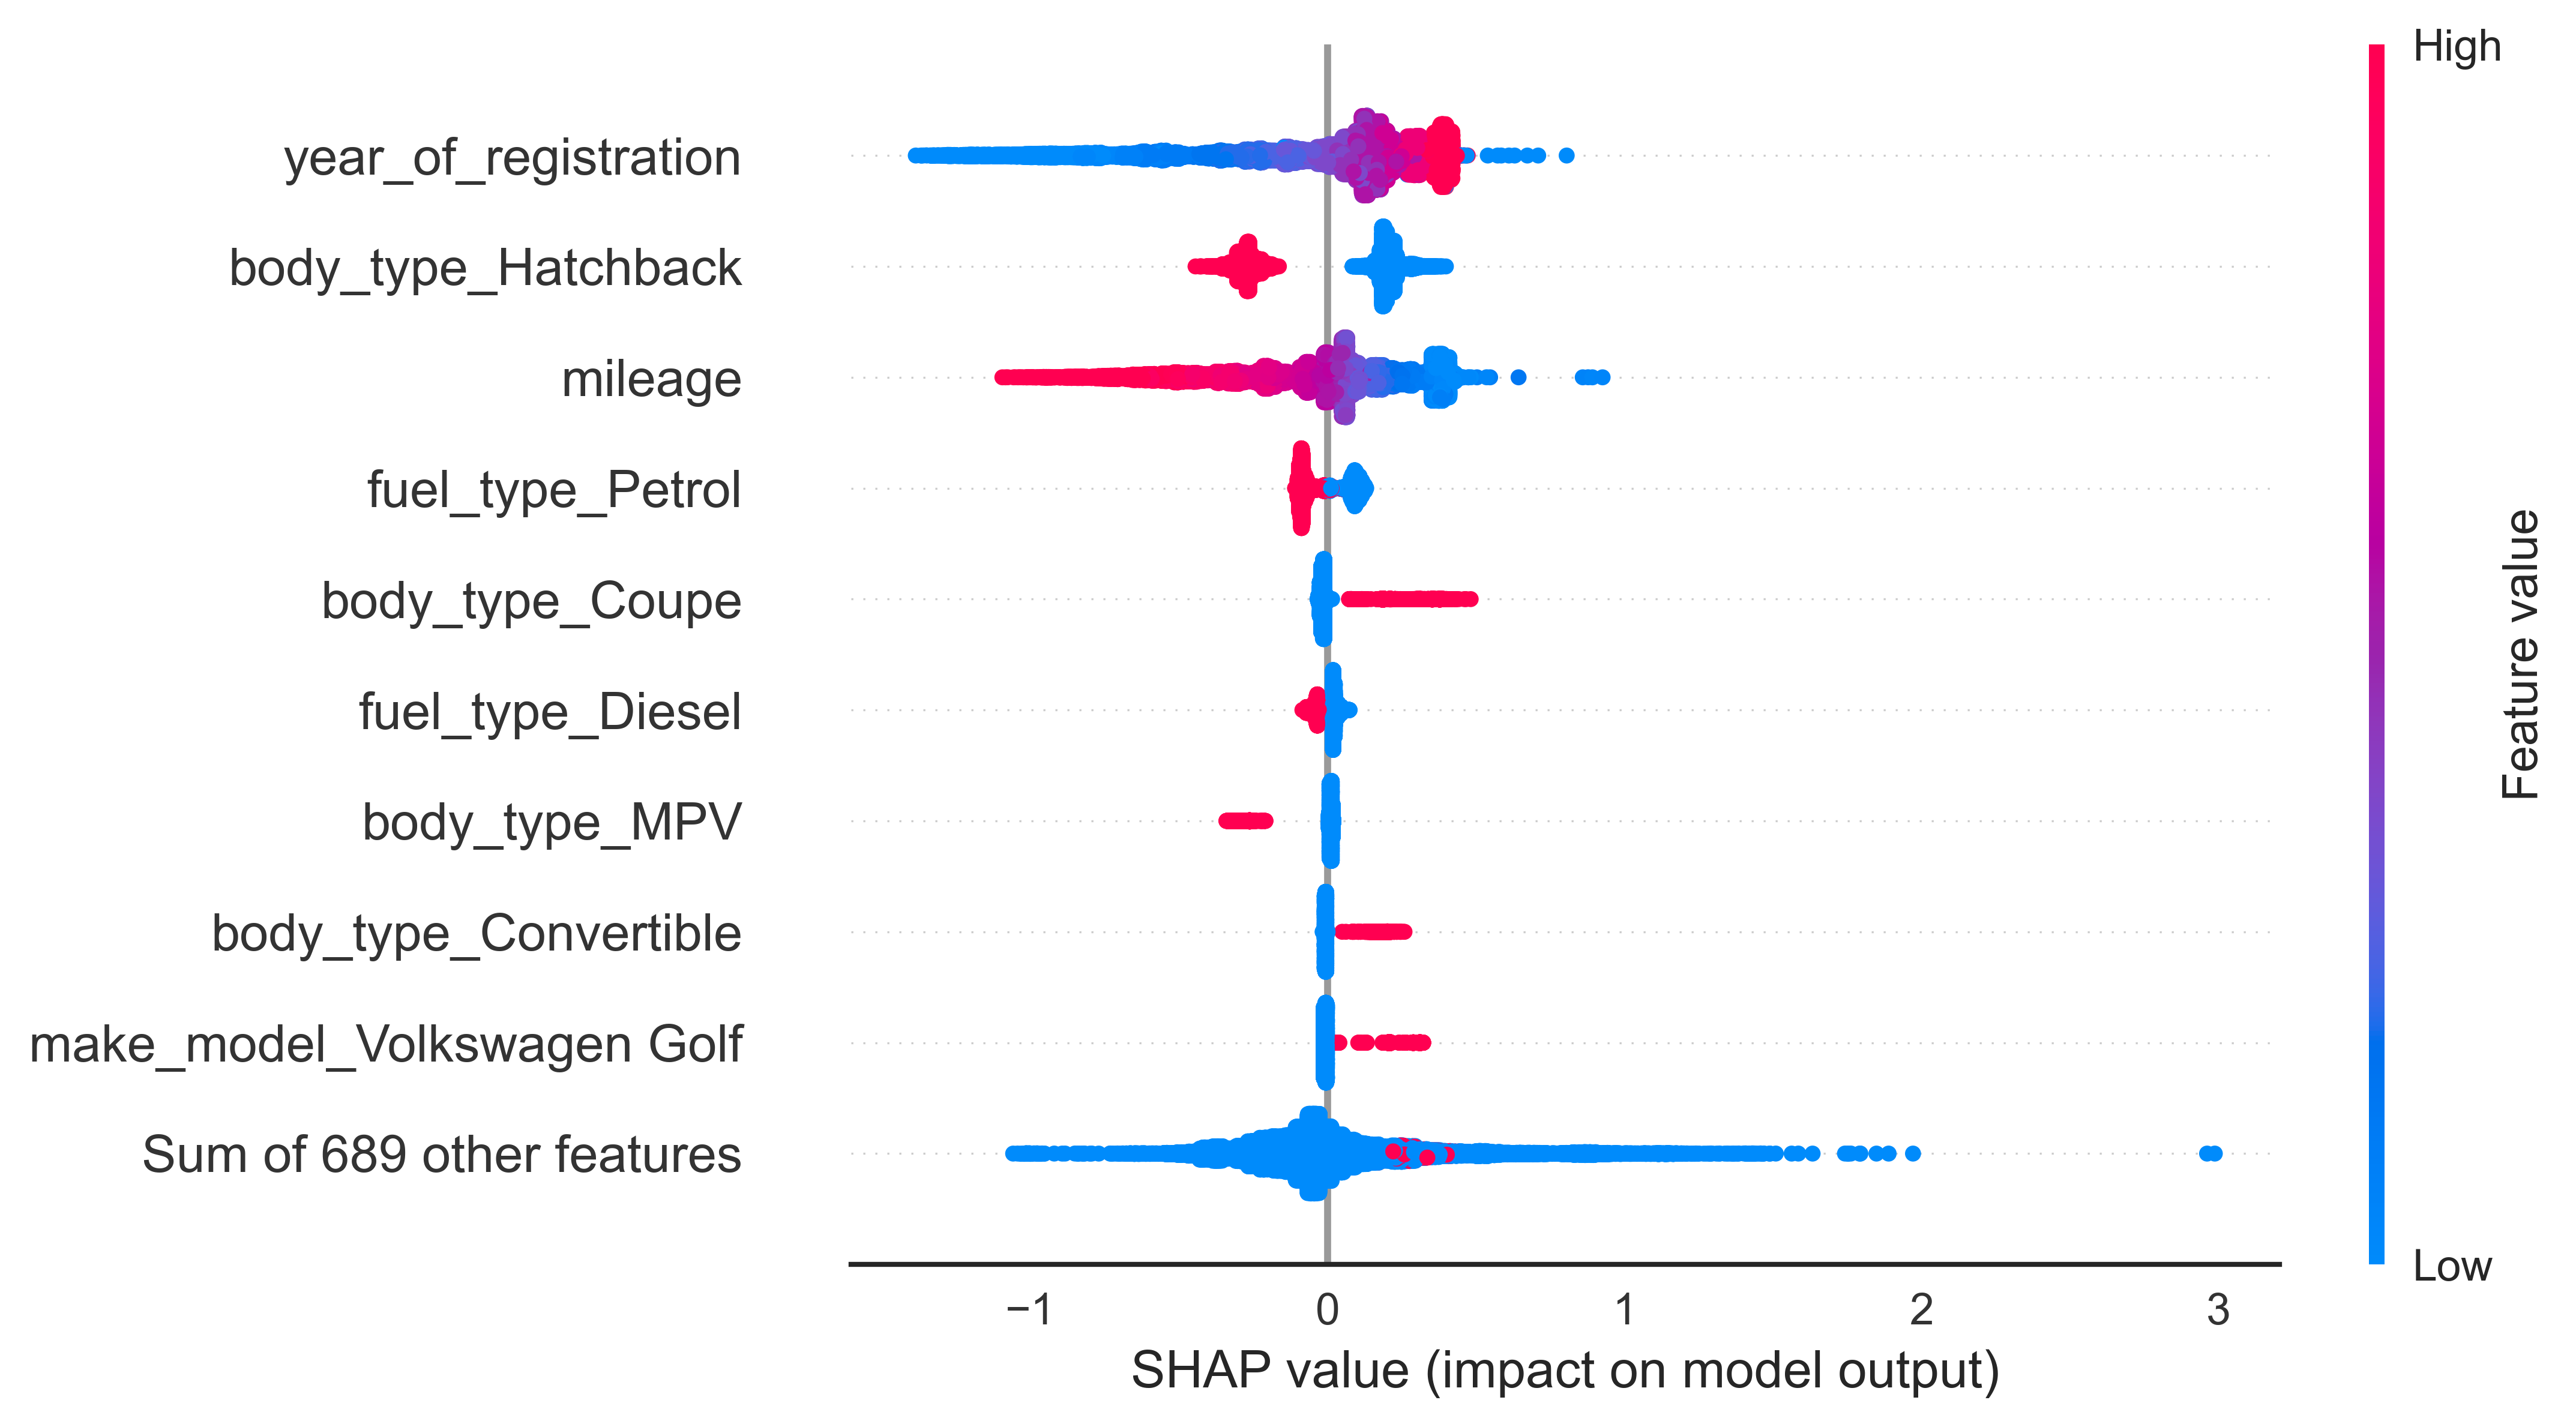

In [908]:
# summarize the effects of all the features
plt.figure(figsize=(12, 5), dpi=240)
shap.plots.beeswarm(shap_values, show=False);

In [ ]:
# visualize the training set predictions
# shap.plots.force(shap_values)

### SHAP Bar Plot

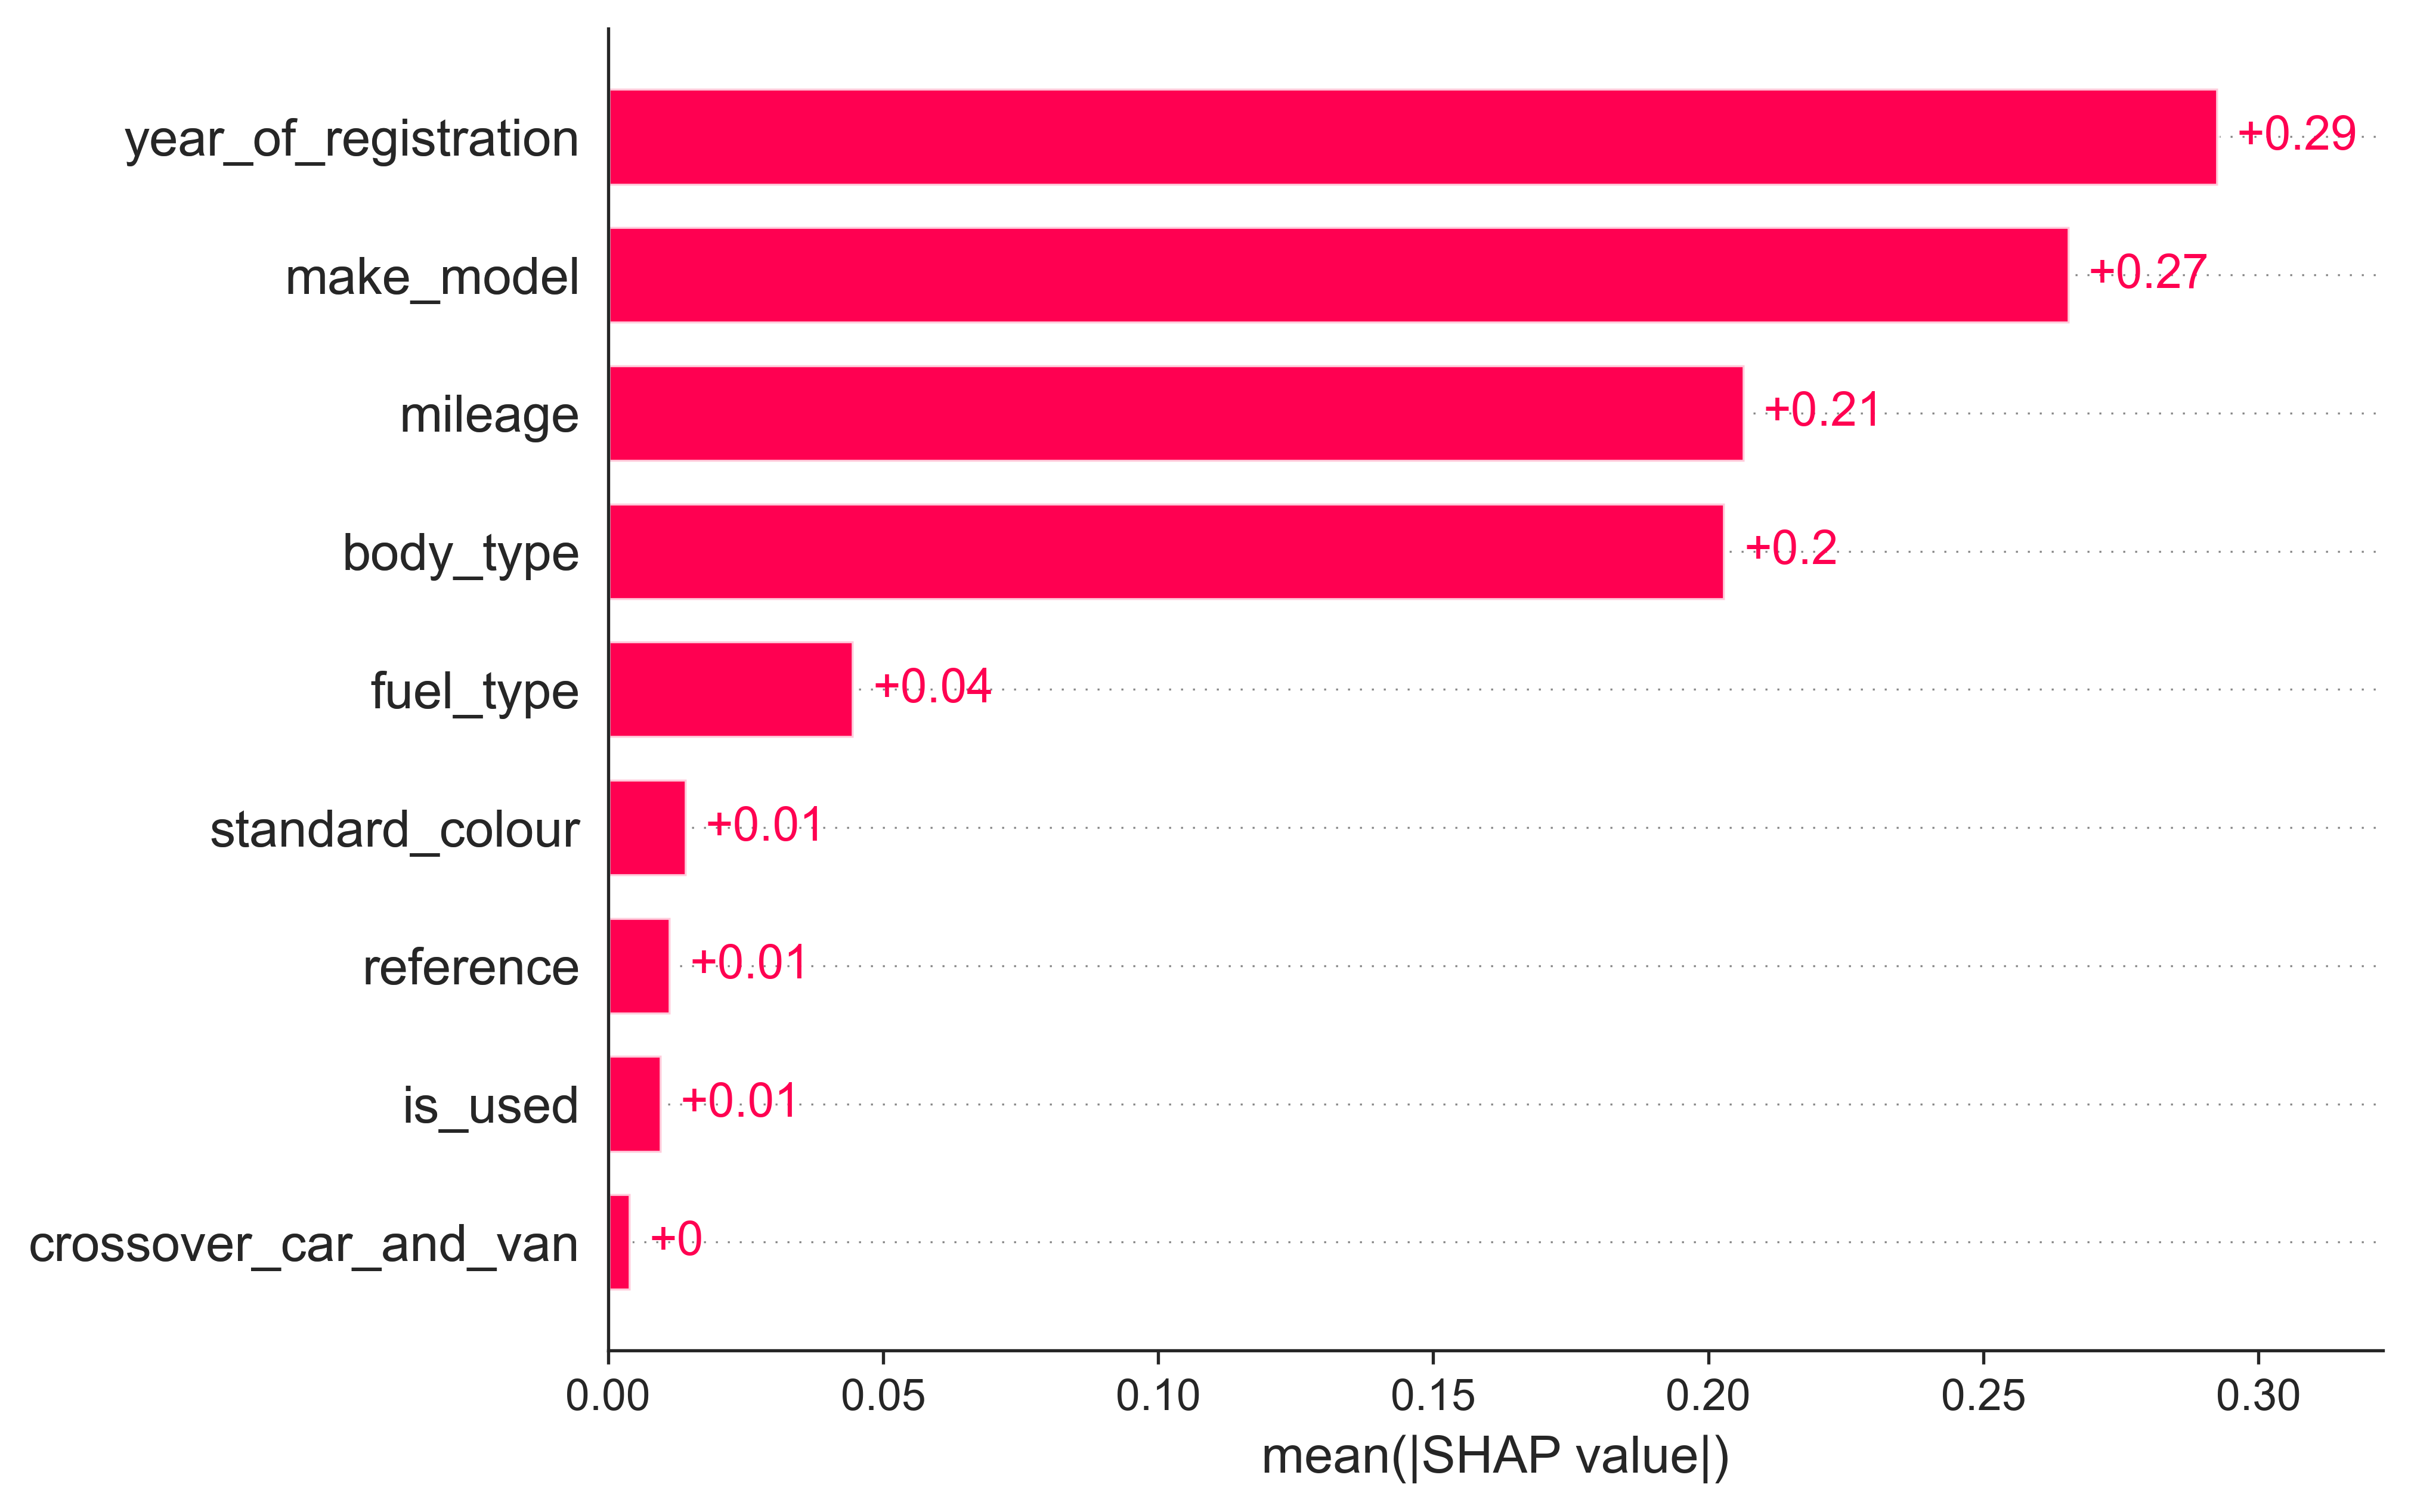

In [ ]:
plt.figure(figsize=(12, 2), dpi=240)
shap.plots.bar(shap_values)

### Pearson Rank2D

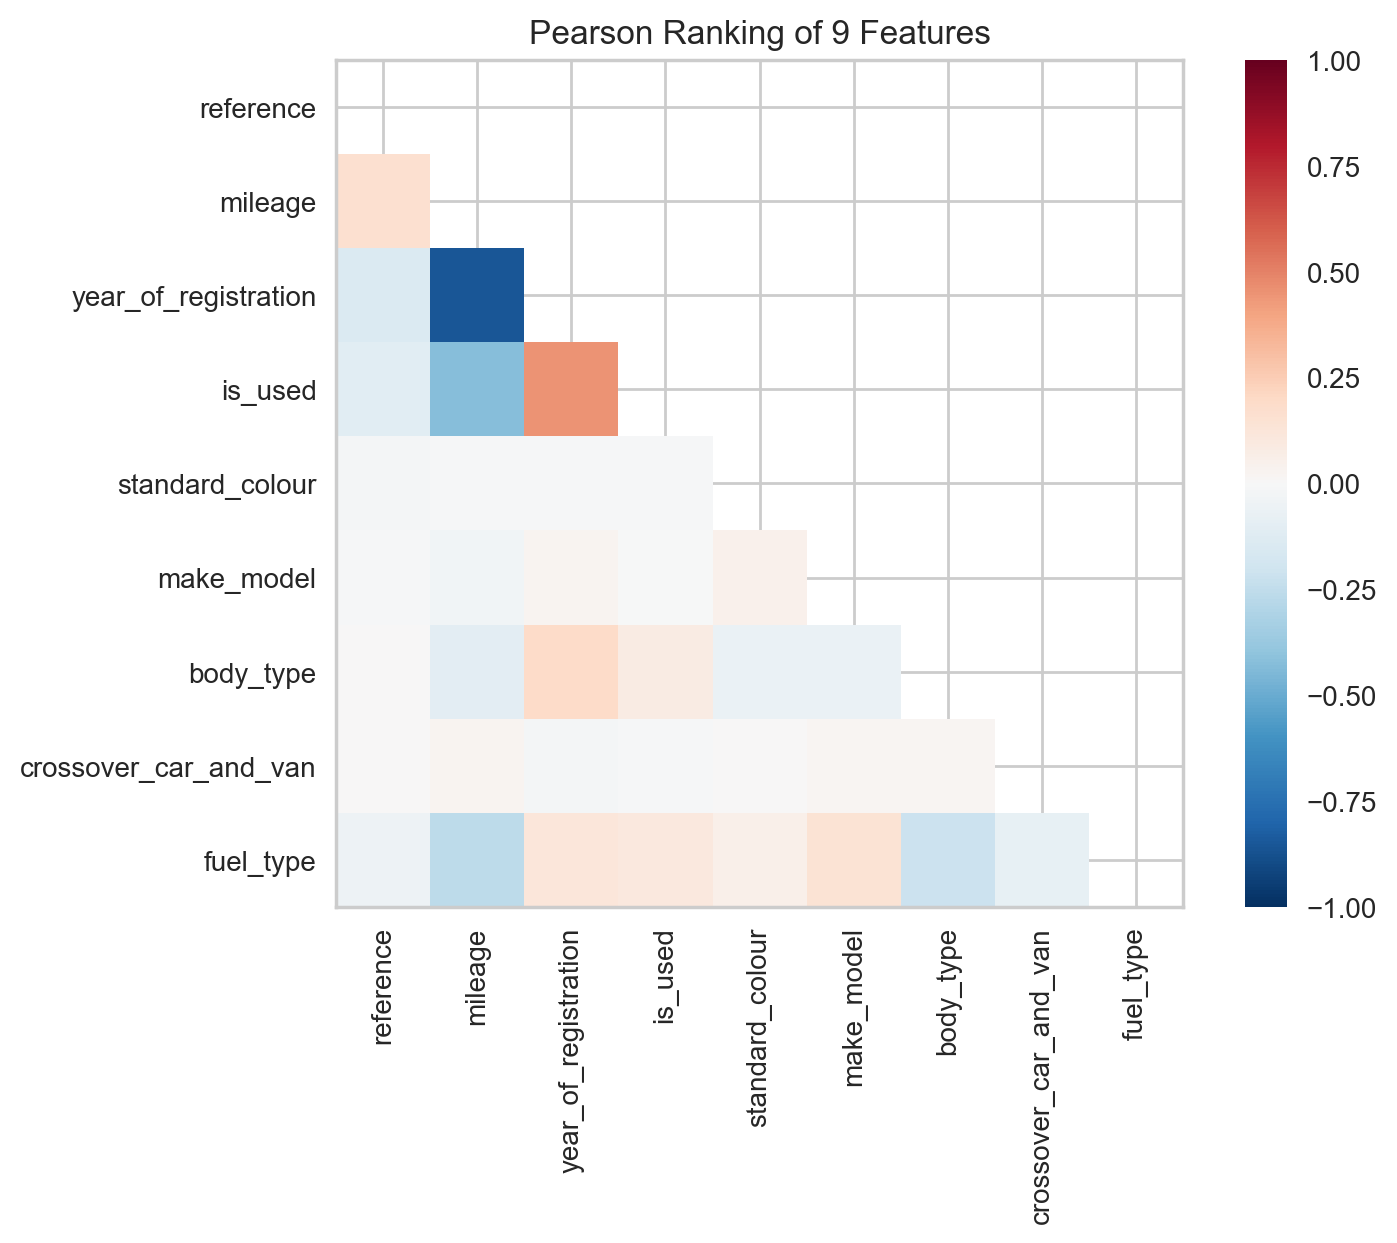

<Axes: title={'center': 'Pearson Ranking of 9 Features'}>

In [ ]:
from yellowbrick.features import Rank2D

visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(X_processed)
visualizer.show()

### PCA

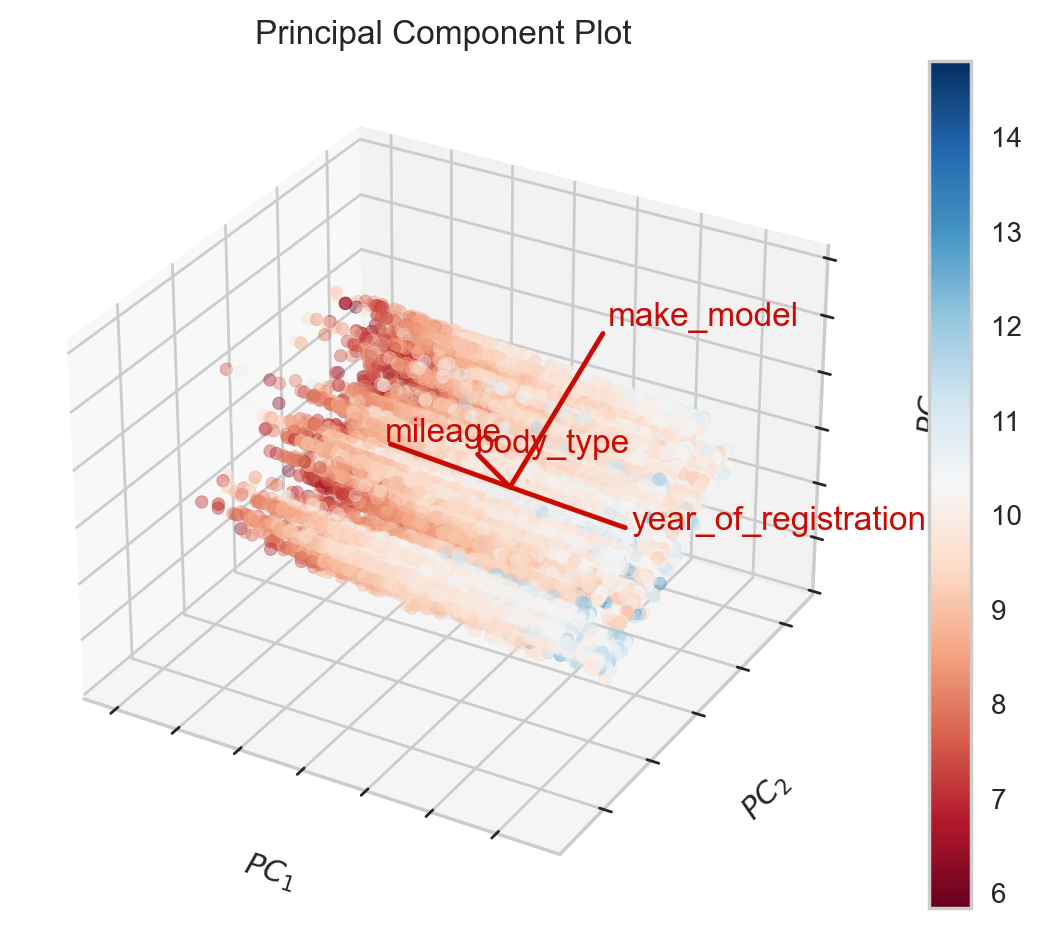

In [ ]:
from yellowbrick.features import PCA

visualizer = PCA(scale=True, alpha=0.4, proj_features=True, projection=3)
visualizer.fit_transform(X_processed[["mileage", "make_model", "year_of_registration", "body_type"]], y_processed)
visualizer.show();

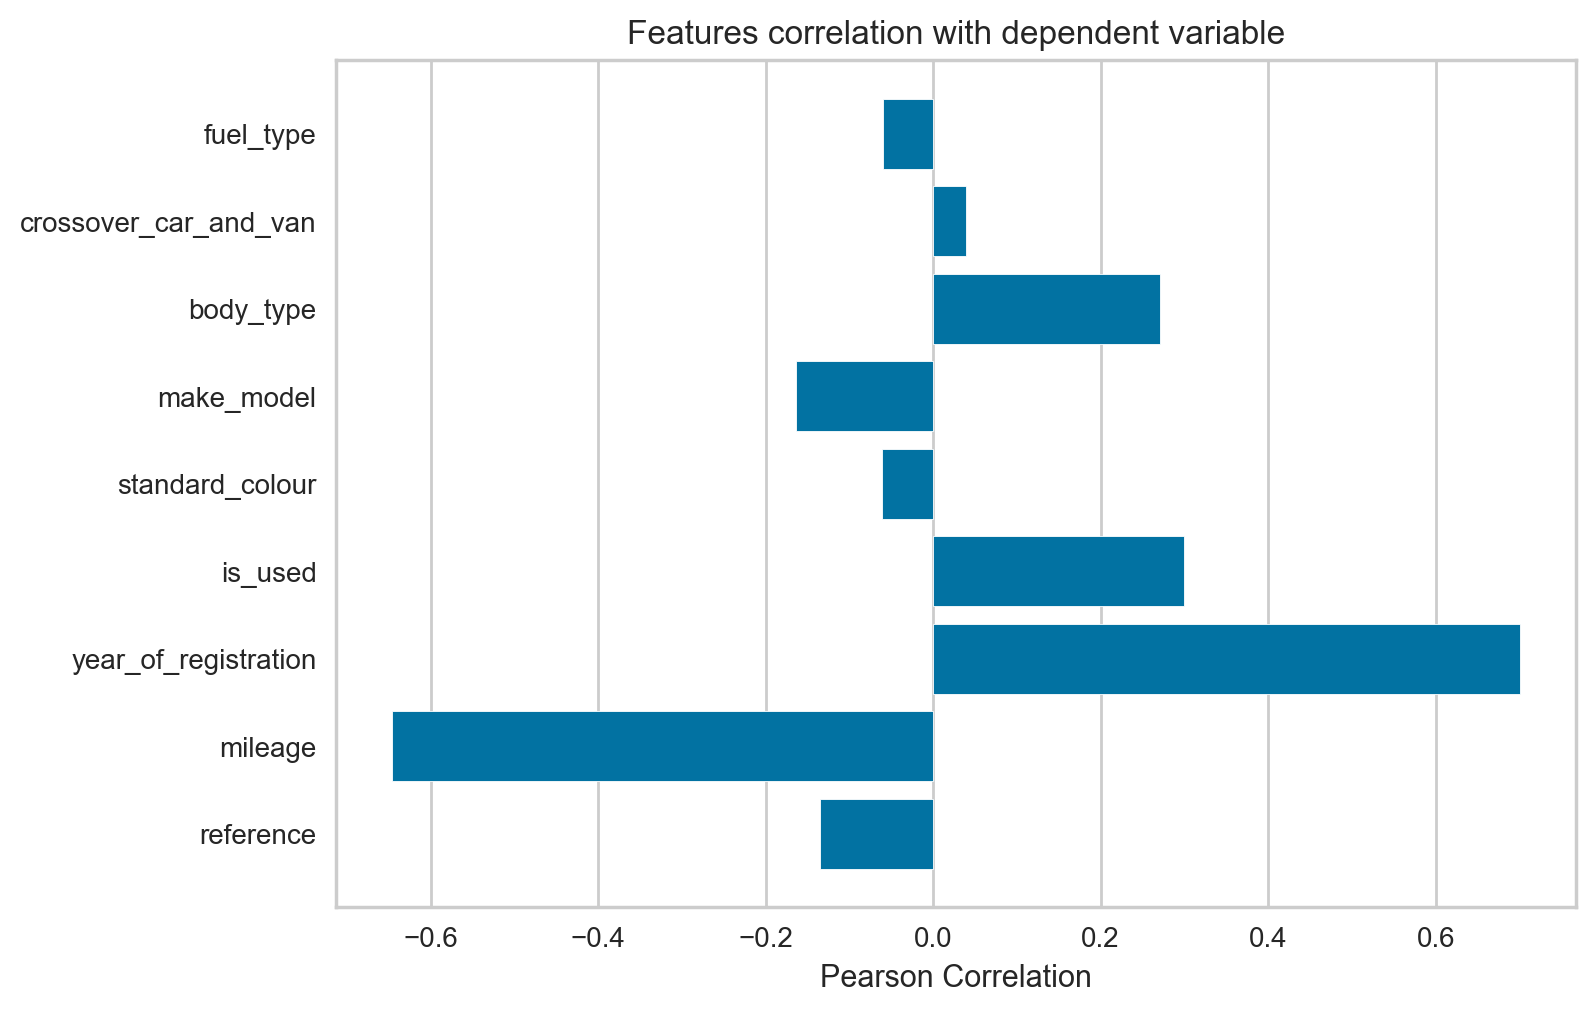

<Axes: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [ ]:
from yellowbrick.target import FeatureCorrelation

# Instantiate the visualizer
visualizer = FeatureCorrelation()

visualizer.fit(X_processed, y_processed)
visualizer.show();

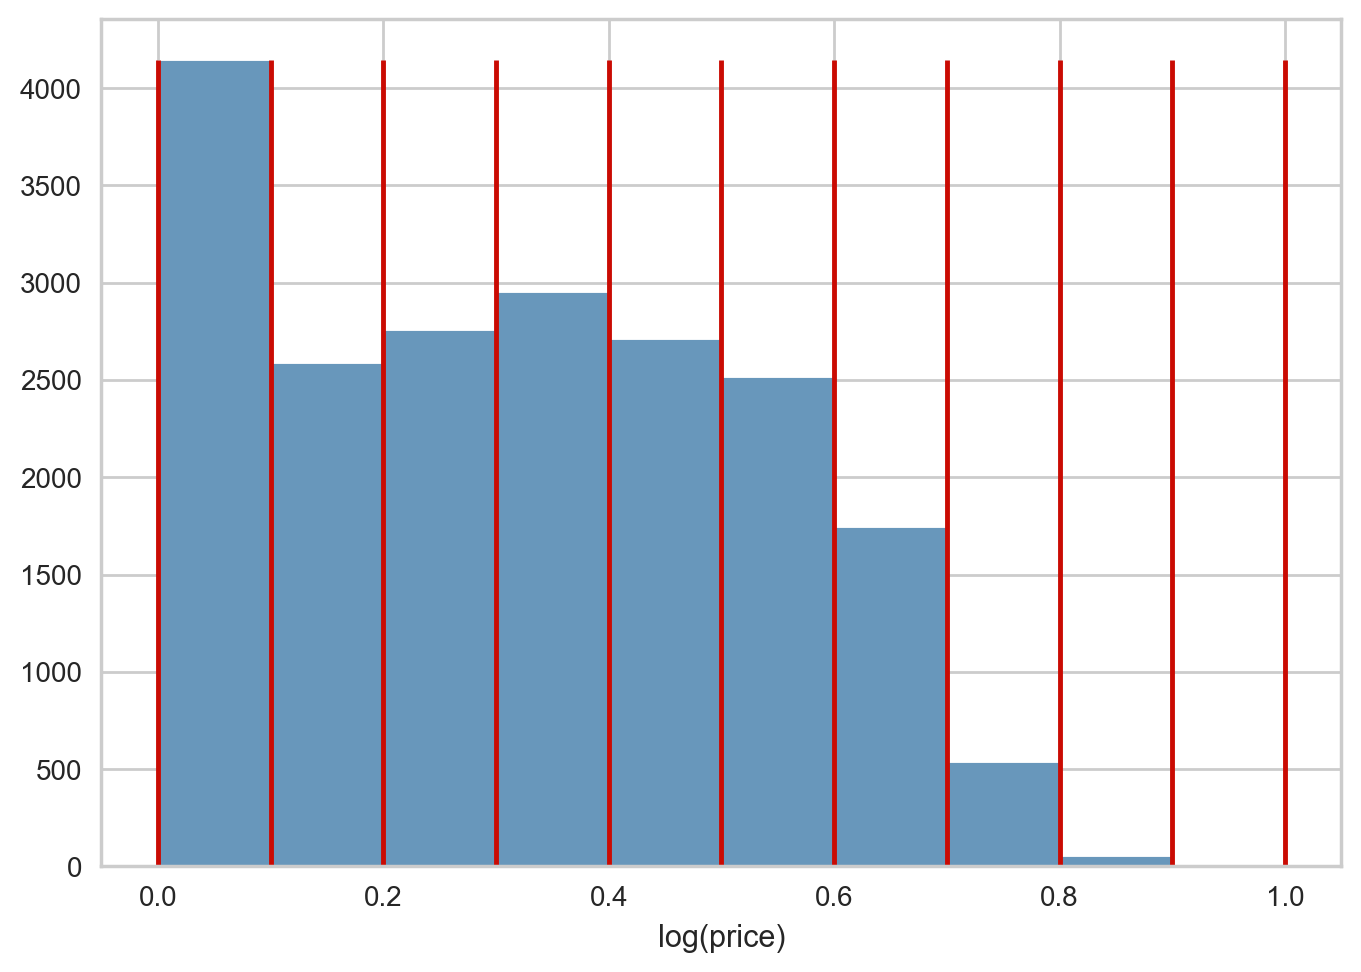

In [ ]:
from yellowbrick.target import BalancedBinningReference

# Instantiate the visualizer
visualizer = BalancedBinningReference(bins=10, target="log(price)")

visualizer.fit(X_processed["mileage"])
visualizer.show();

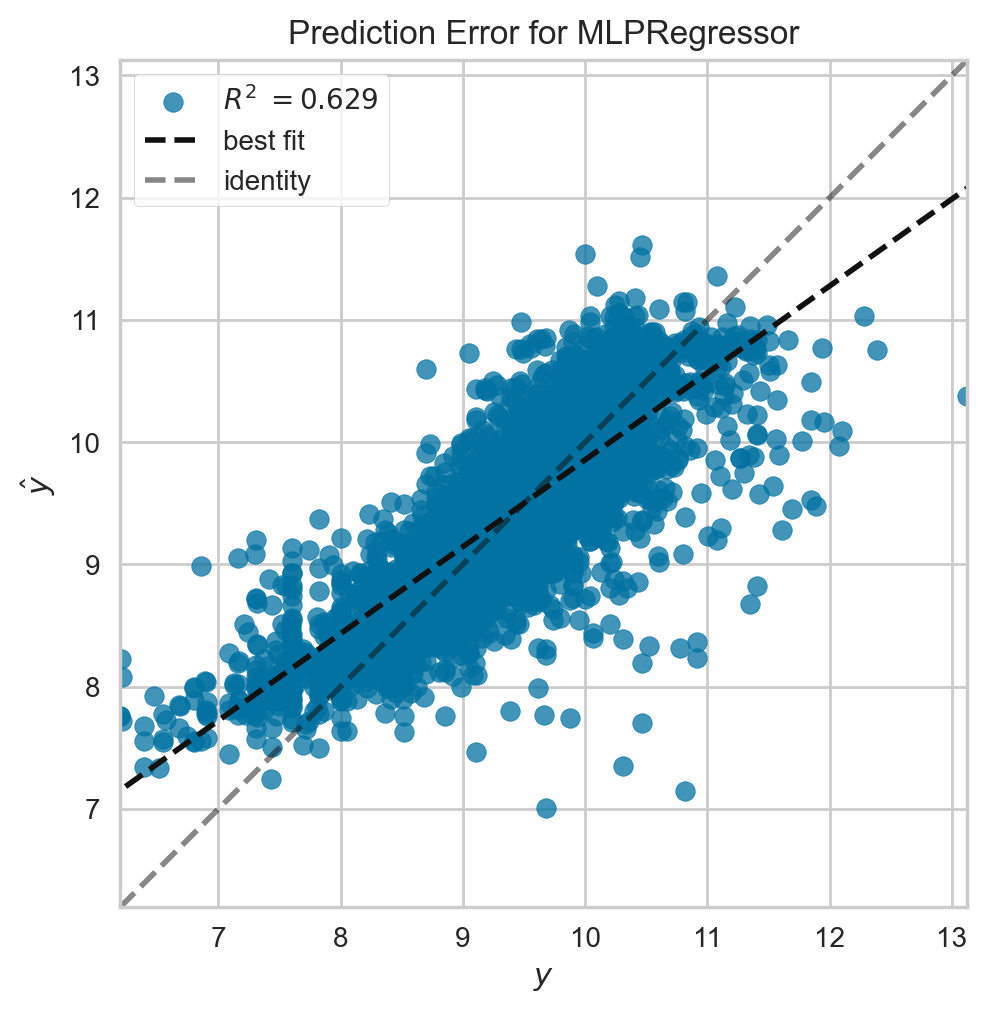

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import prediction_error


# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

# Instantiate the linear model and visualizer
model = MLPRegressor()
visualizer = prediction_error(model, X_train, y_train, X_test, y_test)

In [ ]:
set_encoder(preprocessor, "OneHot")

preprocessor.transform(auto)

ValueError: Length mismatch: Expected axis has 698 elements, new values have 9 elements

In [ ]:


X_processed = preprocessor.fit_transform(auto.drop(columns="log(price)"))
y_processed = auto["log(price)"]

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

ValueError: Length mismatch: Expected axis has 698 elements, new values have 9 elements

In [ ]:
from sklearn.inspection import permutation_importance

model = MLPRegressor()

model.fit(X_train, y_train)

r = permutation_importance(model, X_test, y_test,
                           n_repeats=30,
                           random_state=seed)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train.columns[i]:<8} "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

year_of_registration 0.772 +/- 0.016
body_type 0.201 +/- 0.007
make_model 0.125 +/- 0.005
fuel_type 0.062 +/- 0.006
mileage  0.057 +/- 0.004
is_used  0.012 +/- 0.002
reference 0.006 +/- 0.001
crossover_car_and_van 0.006 +/- 0.001


## SHAP/PDP Model Explanations - 10%
Use SHAP values and Partial Dependence Plots to interpret and explain your models.

# Indranath Section - 40%

## Dimensionality Reduction (Linear) (10%)
Apply and analyse methods like PCA.

## Dimensionality Reduction (Non-Linear) (10%)
Implement and evaluate methods such as Isomap.

## Polynomial Regression (10%)
Build and assess polynomial regression models.

## Clustering for Feature Engineering (10%)
Perform clustering techniques (e.g., K-Means) for deriving new features.

# Train test split

In [ ]:
X, y = auto.drop(columns="price"), auto[["price"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Cross validate models

In [ ]:
# set_config(display="diagram")
# knn_pipeline

In [ ]:
knn_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("knn", KNeighborsRegressor())
])

knn_pipeline.set_params(knn__n_neighbors=5)
scores = cross_val(knn_pipeline, X, y)

Mean Score: 0.664
Score STD: 0.159
All Scores: [0.74219033 0.732103   0.73371415 0.76406332 0.34753544]


<pre style="font-family:monospace;font-size:0.85em">
 Mean Score: 0.853
 Score STD: 0.002
 All Scores: [0.85268541 0.85258516 0.85600912 0.85143071 0.85352867]
</pre>

In [ ]:
dtr_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("dtr", DecisionTreeRegressor())
])

dtr_pipeline.set_params(dtr__max_depth=None, dtr__min_samples_split=22)
scores = cross_val(dtr_pipeline, X, y)

Mean Score: 0.818
Score STD: 0.009
All Scores: [0.83065874 0.81543589 0.82051696 0.81878964 0.80411955]


<pre style="font-family:monospace;font-size:0.85em">
 Mean Score: 0.886
 Score STD: 0.003
 All Scores: [0.8821905  0.88329841 0.88773236 0.8886342  0.88670286]
</pre>

In [ ]:
lnr_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("lnr", LinearRegression())
])

scores = cross_val(lnr_pipeline, X, y)

Mean Score: 0.882
Score STD: 0.007
All Scores: [0.88867635 0.88562632 0.87919444 0.8865497  0.86921631]


<pre style="font-family:monospace;font-size:0.85em">
 Mean Score: 0.897
 Score STD: 0.002
 All Scores: [0.89844907 0.8948629  0.89437632 0.89959797 0.89575401]
</pre>

# Running Models

In [ ]:
dtr_pipeline.set_params(dtr__max_depth=None, dtr__min_samples_split=22)
knn_pipeline.set_params(knn__n_neighbors=5)

models=[];
models.append(('LNR', lnr_pipeline))
models.append(("KNN", knn_pipeline))
models.append(('DTR', dtr_pipeline))
models.append(("FRST", forest_pipe))
models.append(("BST", boost_pipe))
models.append(("MLP", mlp_pipe))
models.append(("STK", stack_pipe))
models.append(("VTE", vote_pipe))
models.append(("VTE2", stack_pipe2))

# Set a seed for reproducibility
np.random.seed(seed)

names=[];
result=[];
for name,model in models:
    k_fold=KFold(n_splits=5, shuffle=True, random_state=seed)
    score=cross_val_score(model, X, y, n_jobs=12, cv=k_fold);
    result.append(score)
    names.append(name)
    print(name, score.mean().round(3), score.std().round(3))

LNR 0.881 0.01
KNN 0.667 0.159
DTR 0.818 0.006
FRST 0.865 0.004
BST 0.78 0.004
MLP 0.883 0.055
STK 0.92 0.023
VTE 0.876 0.012
VTE2 0.912 0.005


<pre style="font-family:monospace;font-size:0.85em">
<strong>MODEL    SCORE    STD</strong>
-----------------------
LNR      0.881    0.010
KNN      0.667    0.159
DTR      0.818    0.006
FRST     0.865    0.004
BST      0.780    0.004
MLP      0.883    0.055
STK      0.920    0.023
VTE      0.876    0.012
VTE2     0.912    0.005
</pre>

<pre style="font-family:monospace;font-size:0.85em">
LNR 
    - mean score: 0.897
    - standard deviation:  0.211
</br>
KNN 
    - mean score: 0.853
    - score std:  0.0.003
</br>
DTR 
    - mean score: 0.886
    - score std:  0.002
</pre>

[Text(0, 0.5, 'Model'), Text(0.5, 0, 'Model Score')]

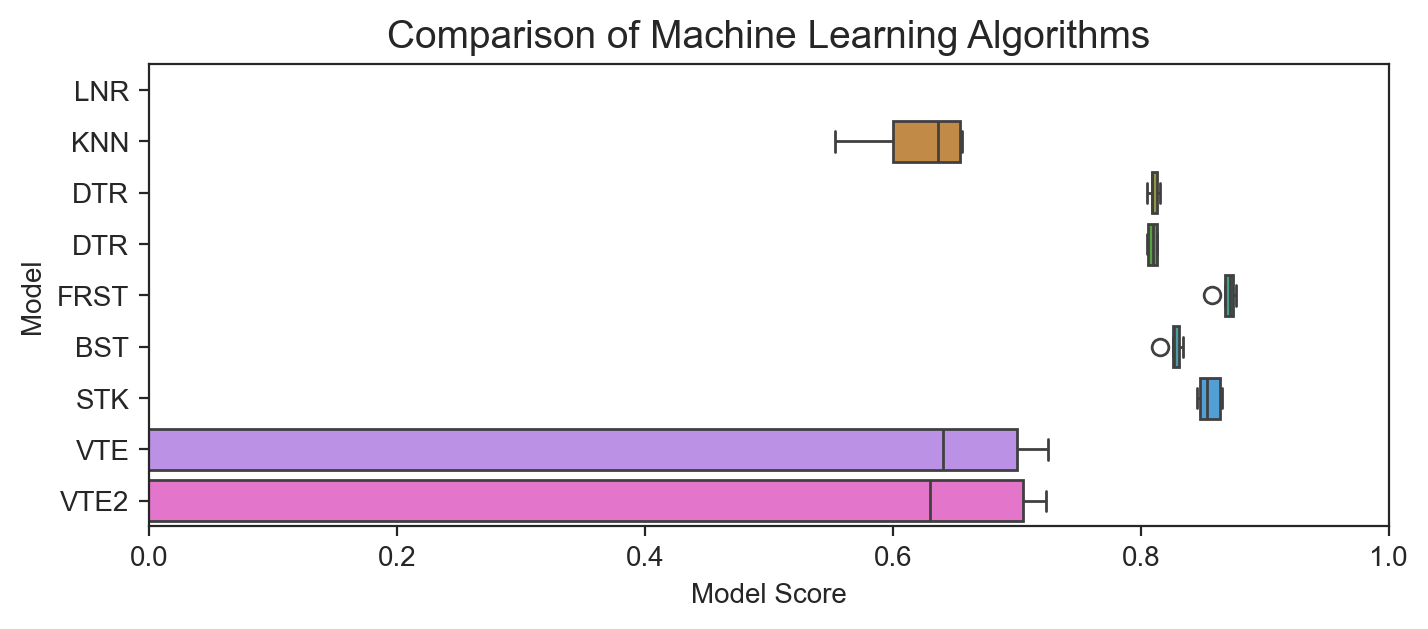

In [ ]:
plt.figure(figsize=(8, 3))
sns.boxplot(result, orient="h")
plt.yticks(range(len(models)), names)
plt.xlim(0, 1)
plt.title('Comparison of Machine Learning Algorithms',fontsize=14)
plt.gca().set(ylabel='Model', xlabel='Model Score');
# plt.savefig("/Users/hal/Documents/Essays/AutoML/algorithm_box_plot4.png", bbox_inches='tight', dpi=240)

# Parameter Evaluation/Grid Search

## Misc Grid Search

### Importance Imputer

In [ ]:
param_grid = {
    'preprocess__pre__cat__imp__similar_threshold': np.arange(1, 20, 2)
}

# Initialize GridSearchCV with the model and parameter grid
clf = GridSearchCV(lnr_pipeline, param_grid, cv=3, n_jobs=6, return_train_score=True)

# Fit the GridSearchCV on the scaled training data
gs_results = clf.fit(X_train, y_train)

# Convert GridSearchCV results to a DataFrame
gs_df = pd.DataFrame(gs_results.cv_results_)

In [ ]:
print("Best one-hot params:", gs_results.best_params_)
gs_df.sort_values('rank_test_score').head()

Best one-hot params: {'preprocess__pre__cat__imp__similar_threshold': 1}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.290324      0.019290         0.052425        0.002094   
1       0.302668      0.016688         0.054234        0.009375   
2       0.574988      0.025948         0.083400        0.003646   
3       0.596971      0.010049         0.083509        0.003053   
4       0.460639      0.005614         0.070720        0.002071   

   param_preprocess__pre__cat__imp__similar_threshold  \
0                                                  1    
1                                                  3    
2                                                  5    
3                                                  7    
4                                                  9    

                                              params  split0_test_score  \
0  {'preprocess__pre__cat__imp__similar_threshold...           0.666637   
1  {'preprocess__pre__cat__imp__similar_threshold...           0.666637   
2  {'preprocess__pre__cat__imp__similar_threshold...           0.666294   
3  {'preprocess__pre__cat__imp__similar_threshold...           0.666294   
4  {'preprocess__pre__cat__imp__similar_threshold...           0.666294   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.644858           0.716343         0.675946        0.029917   
1           0.644858           0.716343         0.675946        0.029917   
2           0.644366           0.716639         0.675766        0.030256   
3           0.644366           0.716639         0.675766        0.030256   
4           0.644366           0.716639         0.675766        0.030256   

   rank_test_score  split0_train_score  split1_train_score  \
0                1            0.946031            0.951782   
1                1            0.946031            0.951782   
2                3            0.946039            0.951682   
3                3            0.946039            0.951682   
4                3            0.946039            0.951682   

   split2_train_score  mean_train_score  std_train_score  
0            0.963024          0.953612         0.007057  
1            0.963024          0.953612         0.007057  
2            0.963024          0.953582         0.007063  
3            0.963024          0.953582         0.007063  
4            0.963024          0.953582         0.007063

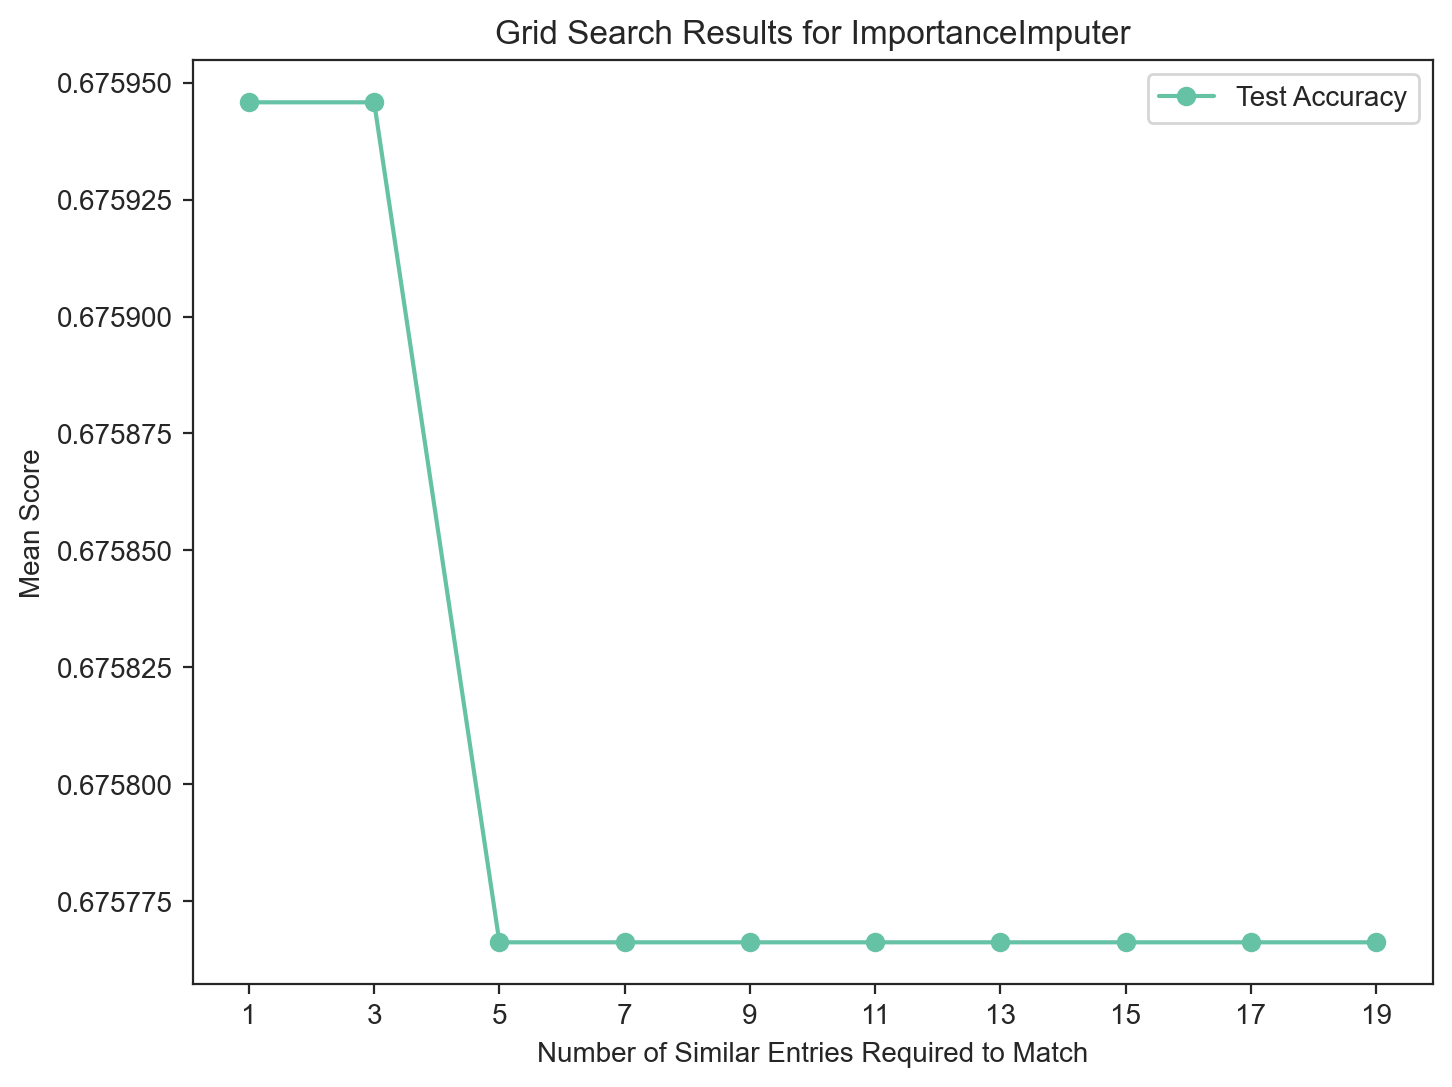

In [ ]:
param_values = gs_df['param_preprocess__pre__cat__imp__similar_threshold'].astype(int)  # Convert to integer if not already
mean_train_scores = gs_df['mean_train_score'].astype(float)
mean_test_scores = gs_df['mean_test_score'].astype(float)

# Create a figure for the plot
plt.figure(figsize=(8, 6))

# Plot both training and test accuracy values
# plt.plot(param_values, mean_train_scores, label='Training Accuracy', marker='o')
plt.plot(param_values, mean_test_scores, label='Test Accuracy', marker='o')

# Label the x-axis and y-axis
plt.xlabel('Number of Similar Entries Required to Match')
plt.ylabel('Mean Score')

# Set x-axis ticks to the 'n_neighbors' values
plt.xticks(param_values)

# Show plot title and display the plot
plt.title('Grid Search Results for ImportanceImputer')
plt.legend()
plt.savefig("/Users/hal/Documents/Essays/AutoML/importance_grid_search.png", bbox_inches='tight', dpi=240)

### OneHotEncoder

In [ ]:
param_grid = {
    'preprocess__pre__cat__ohenc__min_frequency': [1, 2, 5, 10, 30, 50],
    'preprocess__pre__cat__ohenc__max_categories': [10, 100, 200, 300, 400, 500, None],
    'preprocess__pre__cat__ohenc__drop': [None, "first", "if_binary"],
    'preprocess__pre__cat__ohenc__handle_unknown': ['ignore', 'infrequent_if_exist'],
}

# Initialize GridSearchCV with the model and parameter grid
clf = GridSearchCV(lnr_pipeline, param_grid, cv=3, n_jobs=12, return_train_score=True)

# Fit the GridSearchCV on the scaled training data
gs_results = clf.fit(X_train, y_train)

# Convert GridSearchCV results to a DataFrame
gs_df = pd.DataFrame(gs_results.cv_results_)

In [ ]:
print("Best one-hot params:", gs_results.best_params_)
gs_df.sort_values('rank_test_score').head()

Best one-hot params: {'preprocess__pre__cat__ohenc__drop': 'if_binary', 'preprocess__pre__cat__ohenc__handle_unknown': 'ignore', 'preprocess__pre__cat__ohenc__max_categories': 100, 'preprocess__pre__cat__ohenc__min_frequency': 1}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
174       0.852702      0.031318         0.217789        0.028624   
6         0.918692      0.059646         0.182608        0.009397   
180       0.787228      0.030437         0.125199        0.014092   
228       0.623437      0.006740         0.108651        0.006656   
222       0.860815      0.025064         0.134516        0.010778   

    param_preprocess__pre__cat__ohenc__drop  \
174                               if_binary   
6                                      None   
180                               if_binary   
228                               if_binary   
222                               if_binary   

    param_preprocess__pre__cat__ohenc__handle_unknown  \
174                                            ignore   
6                                              ignore   
180                                            ignore   
228                               infrequent_if_exist   
222                               infrequent_if_exist   

    param_preprocess__pre__cat__ohenc__max_categories  \
174                                               100   
6                                                 100   
180                                               200   
228                                               300   
222                                               200   

     param_preprocess__pre__cat__ohenc__min_frequency  \
174                                                 1   
6                                                   1   
180                                                 1   
228                                                 1   
222                                                 1   

                                                params  split0_test_score  \
174  {'preprocess__pre__cat__ohenc__drop': 'if_bina...           0.628128   
6    {'preprocess__pre__cat__ohenc__drop': None, 'p...           0.627745   
180  {'preprocess__pre__cat__ohenc__drop': 'if_bina...           0.666447   
228  {'preprocess__pre__cat__ohenc__drop': 'if_bina...           0.666447   
222  {'preprocess__pre__cat__ohenc__drop': 'if_bina...           0.666447   

     split1_test_score  split2_test_score  mean_test_score  std_test_score  \
174           0.676994           0.729997         0.678373        0.041599   
6             0.676994           0.729997         0.678245        0.041754   
180           0.644683           0.717131         0.676087        0.030352   
228           0.644683           0.717131         0.676087        0.030352   
222           0.644683           0.717131         0.676087        0.030352   

     rank_test_score  split0_train_score  split1_train_score  \
174                1            0.875617            0.869607   
6                  2            0.875617            0.869607   
180                3            0.946031            0.951782   
228                3            0.946031            0.951782   
222                3            0.946031            0.951782   

     split2_train_score  mean_train_score  std_train_score  
174            0.869024          0.871416         0.002980  
6              0.869024          0.871416         0.002980  
180            0.963024          0.953612         0.007057  
228            0.963024          0.953612         0.007057  
222            0.963024          0.953612         0.007057

<pre style="font-family:monospace;font-size:0.9em">
Best one-hot params: {
   'preprocess__pre__cat__ohenc__drop': 'if_binary', 
   'preprocess__pre__cat__ohenc__handle_unknown': 'ignore', 
   'preprocess__pre__cat__ohenc__max_categories': 100, 
   'preprocess__pre__cat__ohenc__min_frequency': 1
   }
</pre>

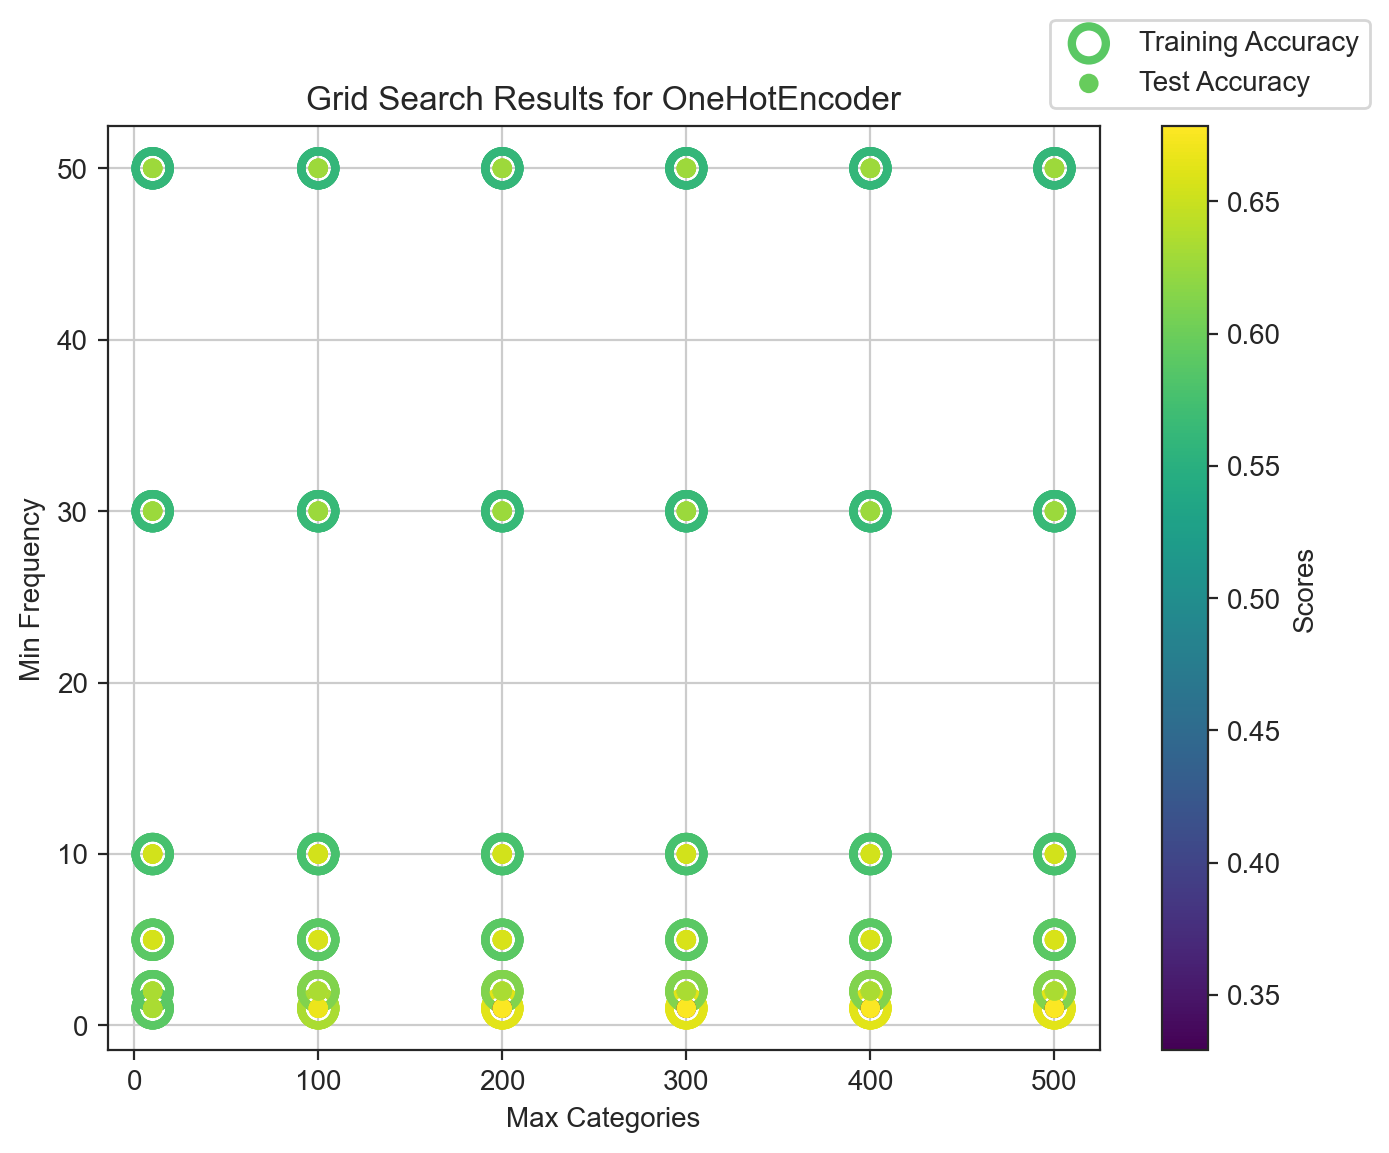

In [ ]:
new_df = gs_df.dropna()
param_vals_1 = new_df['param_preprocess__pre__cat__ohenc__max_categories']
# param_vals_1 = param_vals_1.replace({None: 0})
param_vals_2 = new_df['param_preprocess__pre__cat__ohenc__min_frequency']
# param_vals_2 = param_vals_2.replace({None: 0})

mean_train_scores = new_df['mean_train_score'].astype(float)
mean_test_scores = new_df['mean_test_score'].astype(float)

# Create a figure for the plot
plt.figure(figsize=(8, 6))

plt.scatter(
    param_vals_1, 
    param_vals_2, 
    edgecolors=plt.cm.viridis(mean_train_scores),  # Color for edges
    facecolors='none',  # No fill
    s=150,  # Marker size
    linewidths=3,
    label='Training Accuracy'
)

scatter2 = plt.scatter(param_vals_1, param_vals_2, c=mean_test_scores, cmap='viridis', marker="o", label='Test Accuracy')

# Label the x-axis and y-axis
plt.ylabel('Min Frequency')
plt.xlabel('Max Categories')

# Show plot title and display the plot
plt.title('Grid Search Results for OneHotEncoder')
plt.legend(loc=(0.95, 1.02))
# plt.xticks(param_vals_1.unique())#, [50, 100, 200, 300, 400])
# plt.yticks(param_vals_2.unique())#, [1, 2, 5, 10, 30, 50, 100])
plt.grid(True)
cbar = plt.colorbar(scatter2, cmap="viridis")
cbar.set_label('Scores')
# plt.savefig("/Users/hal/Documents/Essays/AutoML/dtr_grid_search4.png", bbox_inches='tight', dpi=240)

## KNN Grid Search

In [ ]:
# Define the parameter grid for 'n_neighbors' from 1 to 20
param_grid = {
    'knn__n_neighbors': list(range(1, 15))
}

# Initialize GridSearchCV with the model and parameter grid
clf = GridSearchCV(knn_pipeline, param_grid, cv=3, n_jobs=12, return_train_score=True)

# Fit the GridSearchCV on the scaled training data
gs_results = clf.fit(X_train, y_train)

# Convert GridSearchCV results to a DataFrame
gs_df = pd.DataFrame(gs_results.cv_results_)

In [ ]:
# Display specific columns and sort by 'rank_test_score'
gs_df[[
    'param_knn__n_neighbors', 'mean_train_score', 'std_train_score',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]].sort_values('rank_test_score').head()

<style>
    div {
      font-size:0.91em;
    }
    table.dataframe {
      border: 2px solid #3131;
      border-collapse: collapse;
      width: 77%;
      background-color: #1e1e1e;
      color: #ccc;
    }
    table.dataframe th, .dataframe td {
      border: 2px solid #3131;
      text-align: right;
      padding: 0.4%;
    }
    table.dataframe tr {
      background-color: #313131;
    }
    table.dataframe tbody tr:nth-child(even) {
      background-color: #252526;
    }
    table.dataframe tbody tr:nth-child(odd) {
      background-color: #1e1e1e;
    }
  </style>
  
<table class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th>param_knn__n_neighbors</th>
      <th>mean_train_score</th>
      <th>std_train_score</th>
      <th>mean_test_score</th>
      <th>std_test_score</th>
      <th>rank_test_score</th>
    </tr>
  </thead>
  <tbody>
    <tr><th>3</th><td>4</td><td>0.709136</td><td>0.003212</td><td>0.507806</td><td>0.019830</td><td>1</td></tr>
    <tr><th>2</th><td>3</td><td>0.735525</td><td>0.008256</td><td>0.498104</td><td>0.054856</td><td>2</td></tr>
    <tr><th>5</th><td>6</td><td>0.674744</td><td>0.009075</td><td>0.495192</td><td>0.017544</td><td>3</td></tr>
    <tr><th>7</th><td>8</td><td>0.625136</td><td>0.003932</td><td>0.495072</td><td>0.036216</td><td>4</td></tr>
    <tr><th>4</th><td>5</td><td>0.693700</td><td>0.008246</td><td>0.493587</td><td>0.023172</td><td>5</td></tr>
  </tbody>
</table>

In [ ]:
# Retrieve the best parameters found by GridSearchCV
gs_results.best_params_

<pre style="font-family:monospace;font-size:0.83em">
  {'knn__n_neighbors': 4}
</pre>

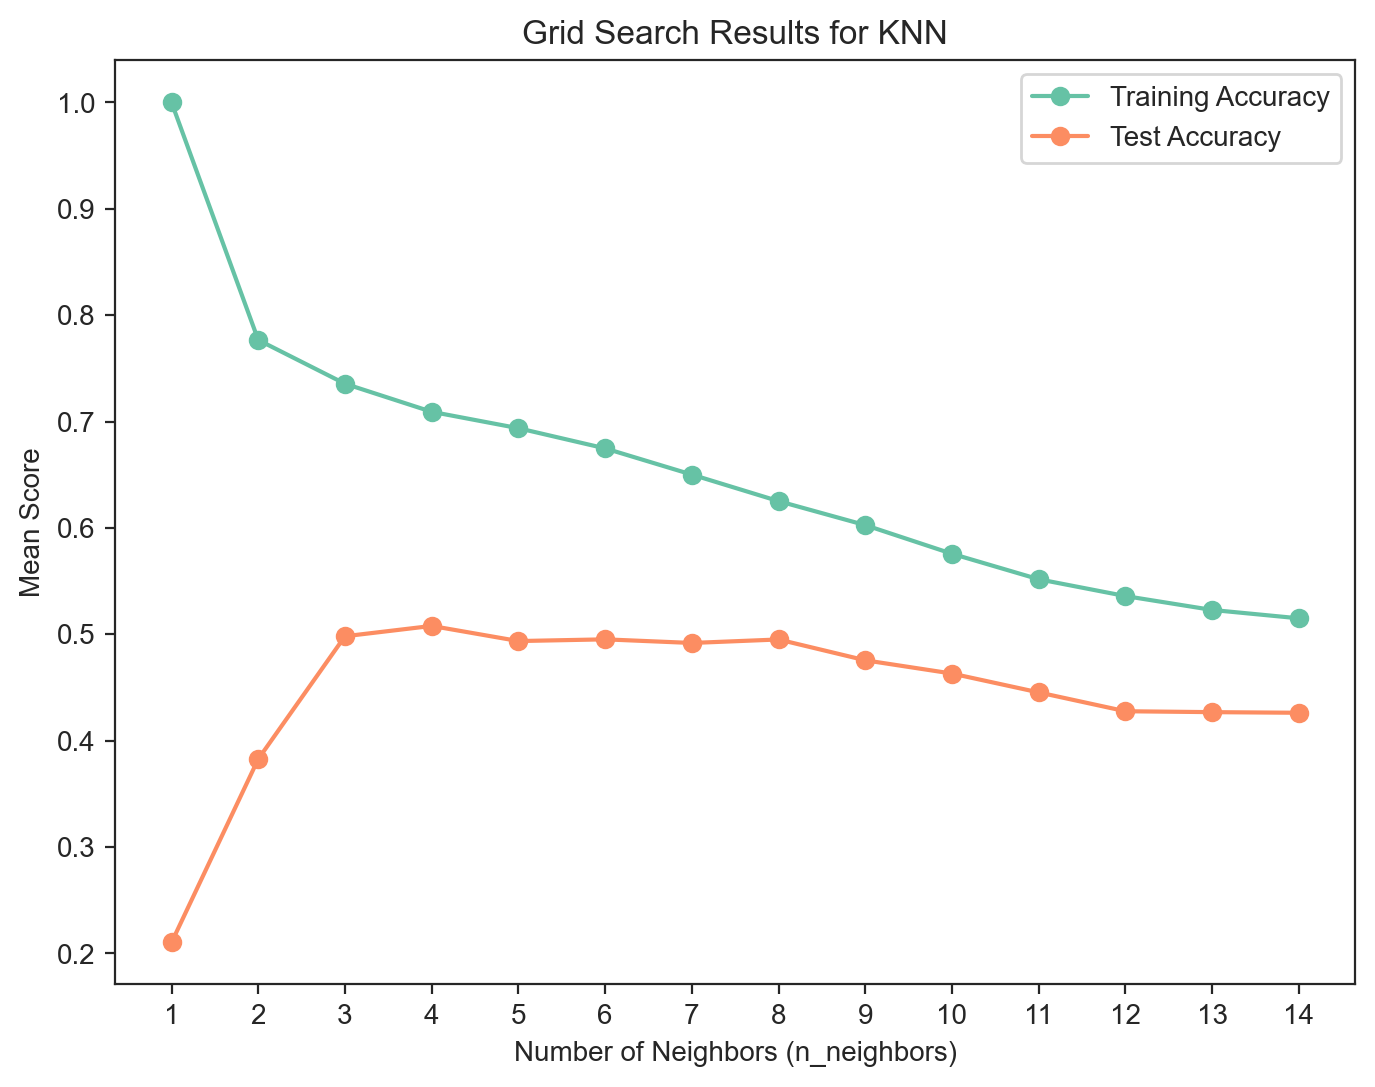

In [ ]:
# Retrieve 'param_n_neighbors' and 'mean_test_score' from the grid search results DataFrame
param_values = gs_df['param_knn__n_neighbors'].astype(int)  # Convert to integer if not already
mean_train_scores = gs_df['mean_train_score'].astype(float)  # Convert to float if not already
mean_test_scores = gs_df['mean_test_score'].astype(float)  # Convert to float if not already

# Create a figure for the plot
plt.figure(figsize=(8, 6))

# Plot both training and test accuracy values
plt.plot(param_values, mean_train_scores, label='Training Accuracy', marker='o')
plt.plot(param_values, mean_test_scores, label='Test Accuracy', marker='o')

# Label the x-axis and y-axis
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('Mean Score')

# Set x-axis ticks to the 'n_neighbors' values
plt.xticks(param_values)

# Show plot title and display the plot
plt.title('Grid Search Results for KNN')
plt.legend()
# plt.savefig("/Users/hal/Documents/Essays/AutoML/knn_grid_search.png", bbox_inches='tight', dpi=240)

## DTR Grid Search

In [ ]:
# Define the parameter grid
param_grid = {
    'dtr__max_depth': [20, 25, 30, 35, 40, 45, 50, 55, 60, None],
    'dtr__min_samples_split': [4, 8, 12, 16, 20, 24, 28, 32],
}

# Initialize GridSearchCV with the model and parameter grid
clf = GridSearchCV(dtr_pipeline, param_grid, cv=5, n_jobs=12, return_train_score=True)

# Fit the GridSearchCV on the scaled training data
gs_results = clf.fit(X_train, y_train)

# Convert GridSearchCV results to a DataFrame
gs_df = pd.DataFrame(gs_results.cv_results_)

In [ ]:
# Display specific columns and sort by 'rank_test_score'
gs_df[[
    'param_dtr__max_depth', 'param_dtr__min_samples_split', 'mean_train_score', 'std_train_score',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]].sort_values('rank_test_score').head(7)

param_dtr__max_depth  param_dtr__min_samples_split  mean_train_score  \
76                 None                            20          0.971061   
75                 None                            16          0.973083   
74                 None                            12          0.974854   
77                 None                            24          0.969671   
66                   60                            12          0.969617   
78                 None                            28          0.968779   
67                   60                            16          0.968065   

    std_train_score  mean_test_score  std_test_score  rank_test_score  
76         0.012283         0.624037        0.252930                1  
75         0.012138         0.623741        0.253275                2  
74         0.011398         0.621572        0.252086                3  
77         0.012264         0.621063        0.250155                4  
66         0.012533         0.620805        0.252103                5  
78         0.012350         0.620538        0.250655                6  
67         0.013219         0.619641        0.252193                7

In [ ]:
# Retrieve the best parameters found by GridSearchCV
gs_results.best_params_

<pre style="font-family:monospace;font-size:0.83em">
 {'dtr__min_samples_split': 22}
</pre>

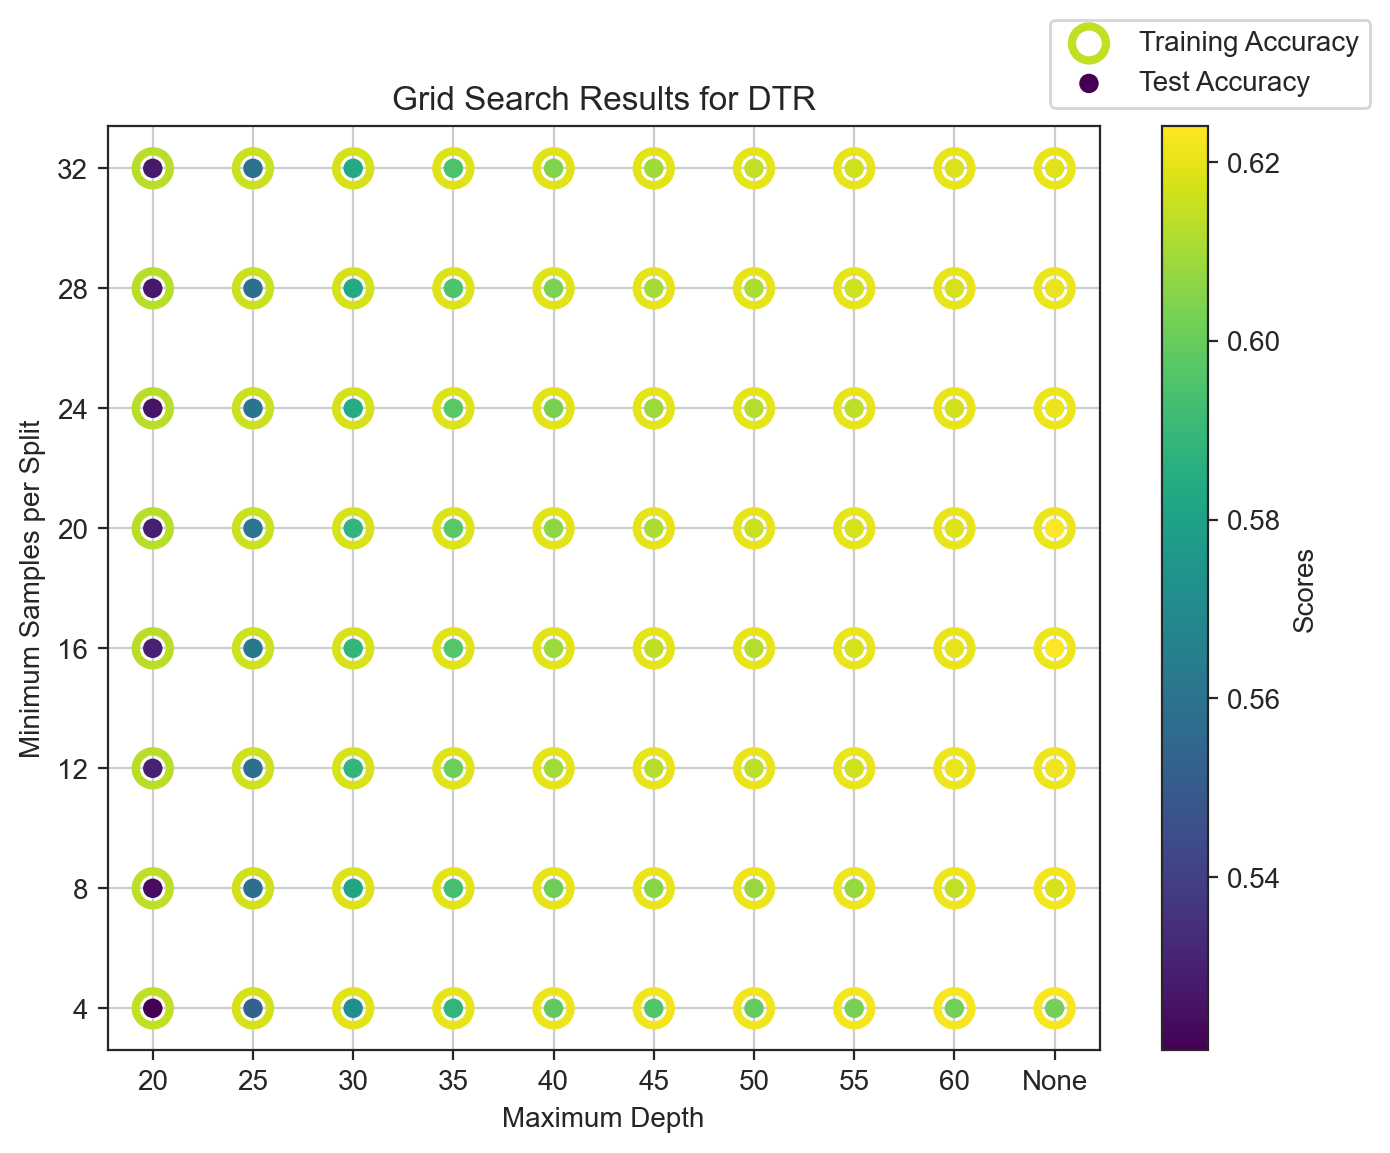

In [ ]:
param_depth = gs_df['param_dtr__max_depth'] 
param_depth = param_depth.replace({None: 65})
param_split = gs_df['param_dtr__min_samples_split'] 

mean_train_scores = gs_df['mean_train_score'].astype(float)
mean_test_scores = gs_df['mean_test_score'].astype(float)

# Create a figure for the plot
plt.figure(figsize=(8, 6))

plt.scatter(
    param_depth, 
    param_split, 
    edgecolors=plt.cm.viridis(mean_train_scores),  # Color for edges
    facecolors='none',  # No fill
    s=150,  # Marker size
    linewidths=3,
    label='Training Accuracy'
)

scatter2 = plt.scatter(param_depth, param_split, c=mean_test_scores, cmap='viridis', marker="o", label='Test Accuracy')

# Label the x-axis and y-axis
plt.xlabel('Maximum Depth')
plt.ylabel('Minimum Samples per Split')

# Show plot title and display the plot
plt.title('Grid Search Results for DTR')
plt.legend(loc=(0.95, 1.02))
plt.xticks([20, 25, 30, 35, 40, 45, 50, 55, 60, 65], [20, 25, 30, 35, 40, 45, 50, 55, 60, "None"])
plt.yticks([4, 8, 12, 16, 20, 24, 28, 32])
plt.grid(True)
cbar = plt.colorbar(scatter2, cmap="viridis")
cbar.set_label('Scores')
plt.savefig("/Users/hal/Documents/Essays/AutoML/dtr_grid_search4.png", bbox_inches='tight', dpi=240)

In [ ]:
%%capture
from matplotlib.animation import FuncAnimation

# Create a 3D scatter plot with Seaborn
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(param_depth, param_split, mean_test_scores, c=mean_test_scores, cmap='viridis')
ax.set_xlabel('Max depth')
ax.set_ylabel('Min Samples Split')
ax.set_zlabel('Score')
plt.title('3D Scatter Plot')

# Function to update the view angle for each frame
def update(frame):
    ax.view_init(elev=30, azim=frame/2)  # Rotate the view
    return ax,

# Create the animation
frames = list(range(180)) + list(range(180, 0, -1))
ani = FuncAnimation(fig, update, frames=frames, interval=20, blit=False);

# Save as MP4
ani.save("3d_scatter_rotation.mp4", writer="ffmpeg", fps=30);

<video src="3d_scatter_rotation.mp4" alt="3d_scatter_rotation" width="700" controls loop />

# Analysis

## Predictions

In [ ]:
knn_pipeline.set_params(knn__n_neighbors=5)
knn_pipeline.fit(X_train, y_train)
actual = y_test.to_numpy().ravel()
knn_predicted = knn_pipeline.predict(X_test).ravel()

prediction_df = pd.DataFrame({'Actual': actual, 'KNN_Predicted': knn_predicted})

knn_pipeline.score(X_test, y_test)

<pre style="font-family:monospace;font-size:0.9em">
0.8444806979046264
</pre>

In [ ]:
dtr_pipeline.set_params(dtr__max_depth=None, dtr__min_samples_split=22)
dtr_pipeline.fit(X_train, y_train)
dtr_predicted = dtr_pipeline.predict(X_test).ravel()

prediction_df["DTR_Predicted"] = dtr_predicted

dtr_pipeline.score(X_test, y_test)

<pre style="font-family:monospace;font-size:0.83em">
0.8845917409362356
</pre>

In [ ]:
dtr = dtr_pipeline.named_steps["dtr"]
dtr.get_depth()

In [ ]:
lnr_pipeline.fit(X_train, y_train)
lnr_predicted = lnr_pipeline.predict(X_test).ravel()

prediction_df["LNR_Predicted"] = lnr_predicted

lnr_pipeline.score(X_test, y_test)

<pre style="font-family:monospace;font-size:0.83em">
0.8989480274222771
</pre>

In [ ]:
# Un-transform the price
prediction_scaled = prediction_df.copy()
prediction_scaled["Actual"]        = np.e**prediction_df["Actual"]
prediction_scaled["KNN_Predicted"] = np.e**prediction_df["KNN_Predicted"]
prediction_scaled["DTR_Predicted"] = np.e**prediction_df["DTR_Predicted"]
prediction_scaled["LNR_Predicted"] = np.e**prediction_df["LNR_Predicted"]

# Scale price to 1000s of pounds for readability
prediction_scaled["Actual"]        = prediction_scaled["Actual"]/1000
prediction_scaled["KNN_Predicted"] = prediction_scaled["KNN_Predicted"]/1000
prediction_scaled["DTR_Predicted"] = prediction_scaled["DTR_Predicted"]/1000
prediction_scaled["LNR_Predicted"] = prediction_scaled["LNR_Predicted"]/1000

In [ ]:
# Find the linear model's worst predictions

dif = prediction_scaled["Actual"] - prediction_scaled["LNR_Predicted"]
worst_predictions = dif.sort_values()
worst_predictions
X_cars_pred = X_test.reset_index(drop=True)[["year_of_registration", "standard_colour", "standard_make", "standard_model"]]
worst_pred_cars = X_cars_pred.loc[worst_predictions.index]

worst_pred_cars["Off_by"] = worst_predictions
worst_pred_cars["Off_by"] = worst_pred_cars["Off_by"].round(3)
worst_pred_cars.to_csv("lnr_worst.csv")
worst_pred_cars

worst_pred_cars = worst_pred_cars.dropna()
worst_pred_cars["year_of_registration"] = worst_pred_cars["year_of_registration"].astype(int)
worst_pred_cars["name"] = worst_pred_cars["year_of_registration"].astype(str) + " " +  worst_pred_cars["standard_make"] + " " + worst_pred_cars["standard_model"]
worst_pred_cars["price"] = prediction_scaled.loc[worst_predictions.index, "Actual"]*1000
worst_pred_cars["off by percent"] = worst_pred_cars["Off_by"]/ worst_pred_cars["price"]
worst_pred_cars["off by percent"] = worst_pred_cars["off by percent"] * 100
worst_pred_cars[["name", "Off_by", "off by percent"]].sort_values(by="off by percent").head(10).to_csv("lnr_worst.csv")

## Plot a sample of predictions

In [ ]:
plot_sample_size = 10

df_plot = prediction_scaled.sample(plot_sample_size, random_state=seed)

X_cars = X_test.reset_index(drop=True)[["year_of_registration", "standard_colour", "standard_make", "standard_model"]]
X_cars_sample = X_cars.loc[df_plot.index]
X_cars_sample["year_of_registration"] = X_cars_sample["year_of_registration"].astype(int)
X_cars_sample["name"] = X_cars_sample["year_of_registration"].astype(str) + " " +  X_cars_sample["standard_make"] + " " + X_cars_sample["standard_model"]

In [ ]:
df_with_names = df_plot.copy()
df_with_names["Name"] = X_cars_sample["name"]
df_with_names["KNN_Predicted"] = df_with_names["KNN_Predicted"].round(3)
df_with_names["DTR_Predicted"] = df_with_names["DTR_Predicted"].round(3)
df_with_names["LNR_Predicted"] = df_with_names["LNR_Predicted"].round(3)
df_with_names.to_csv("predictions.csv")

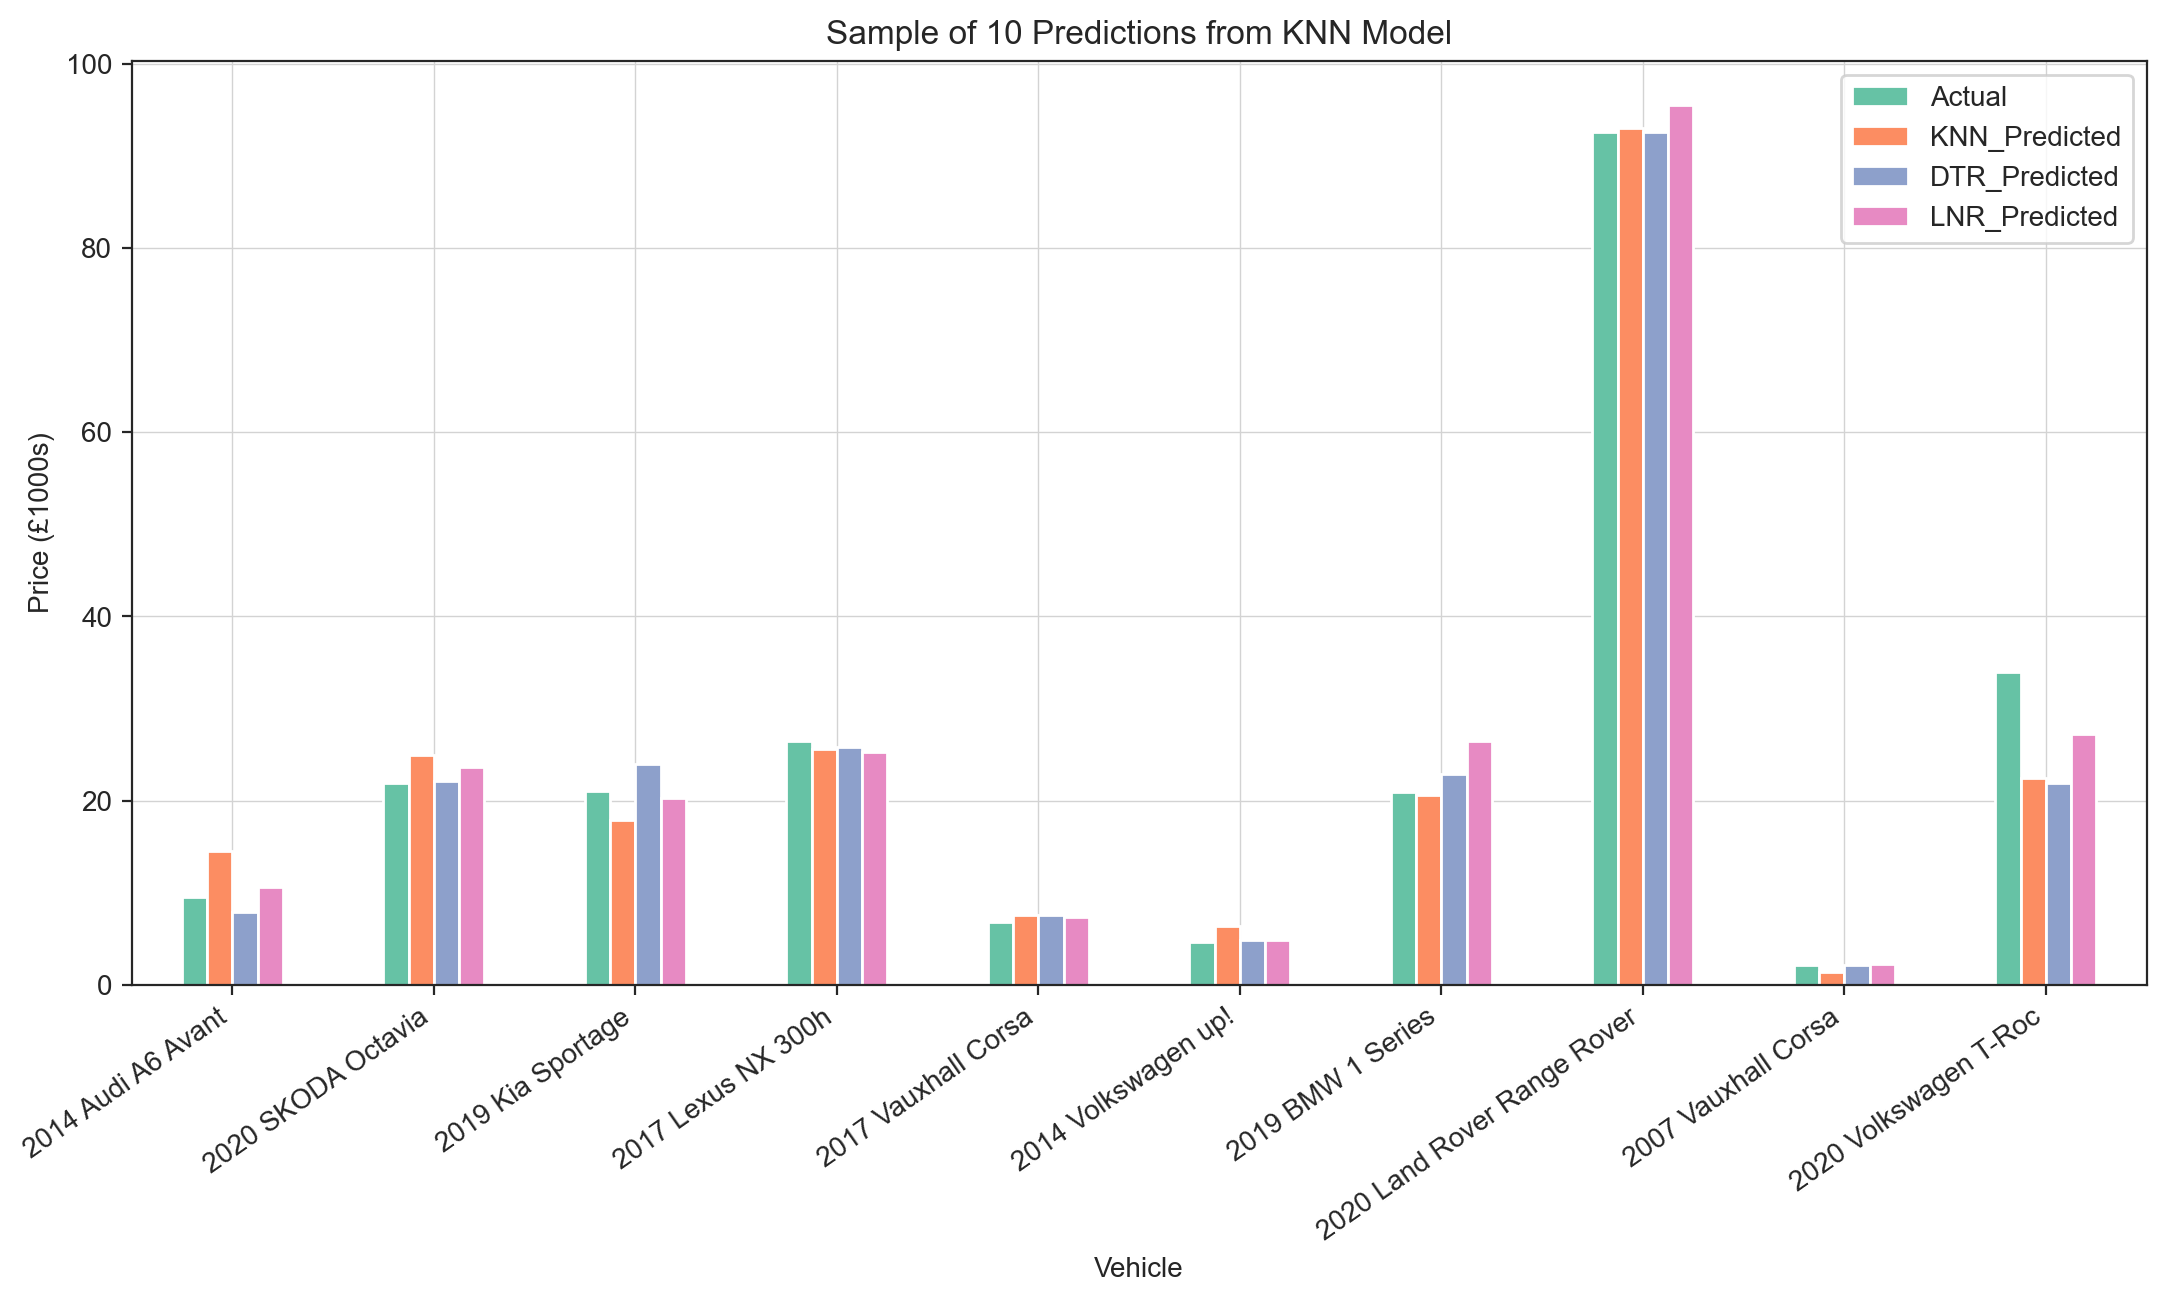

In [ ]:
df_plot.plot(kind='bar',figsize=(13,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='lightgray')
plt.xticks(ticks=np.arange(0, plot_sample_size), labels=X_cars_sample["name"], rotation=35, ha="right")
plt.title("Sample of 10 Predictions from KNN Model")
plt.ylabel("Price (£1000s)")
plt.xlabel("Vehicle");
plt.savefig("/Users/hal/Documents/Essays/AutoML/mixed_results_sample2.png", bbox_inches='tight', dpi=200)

## Residuals

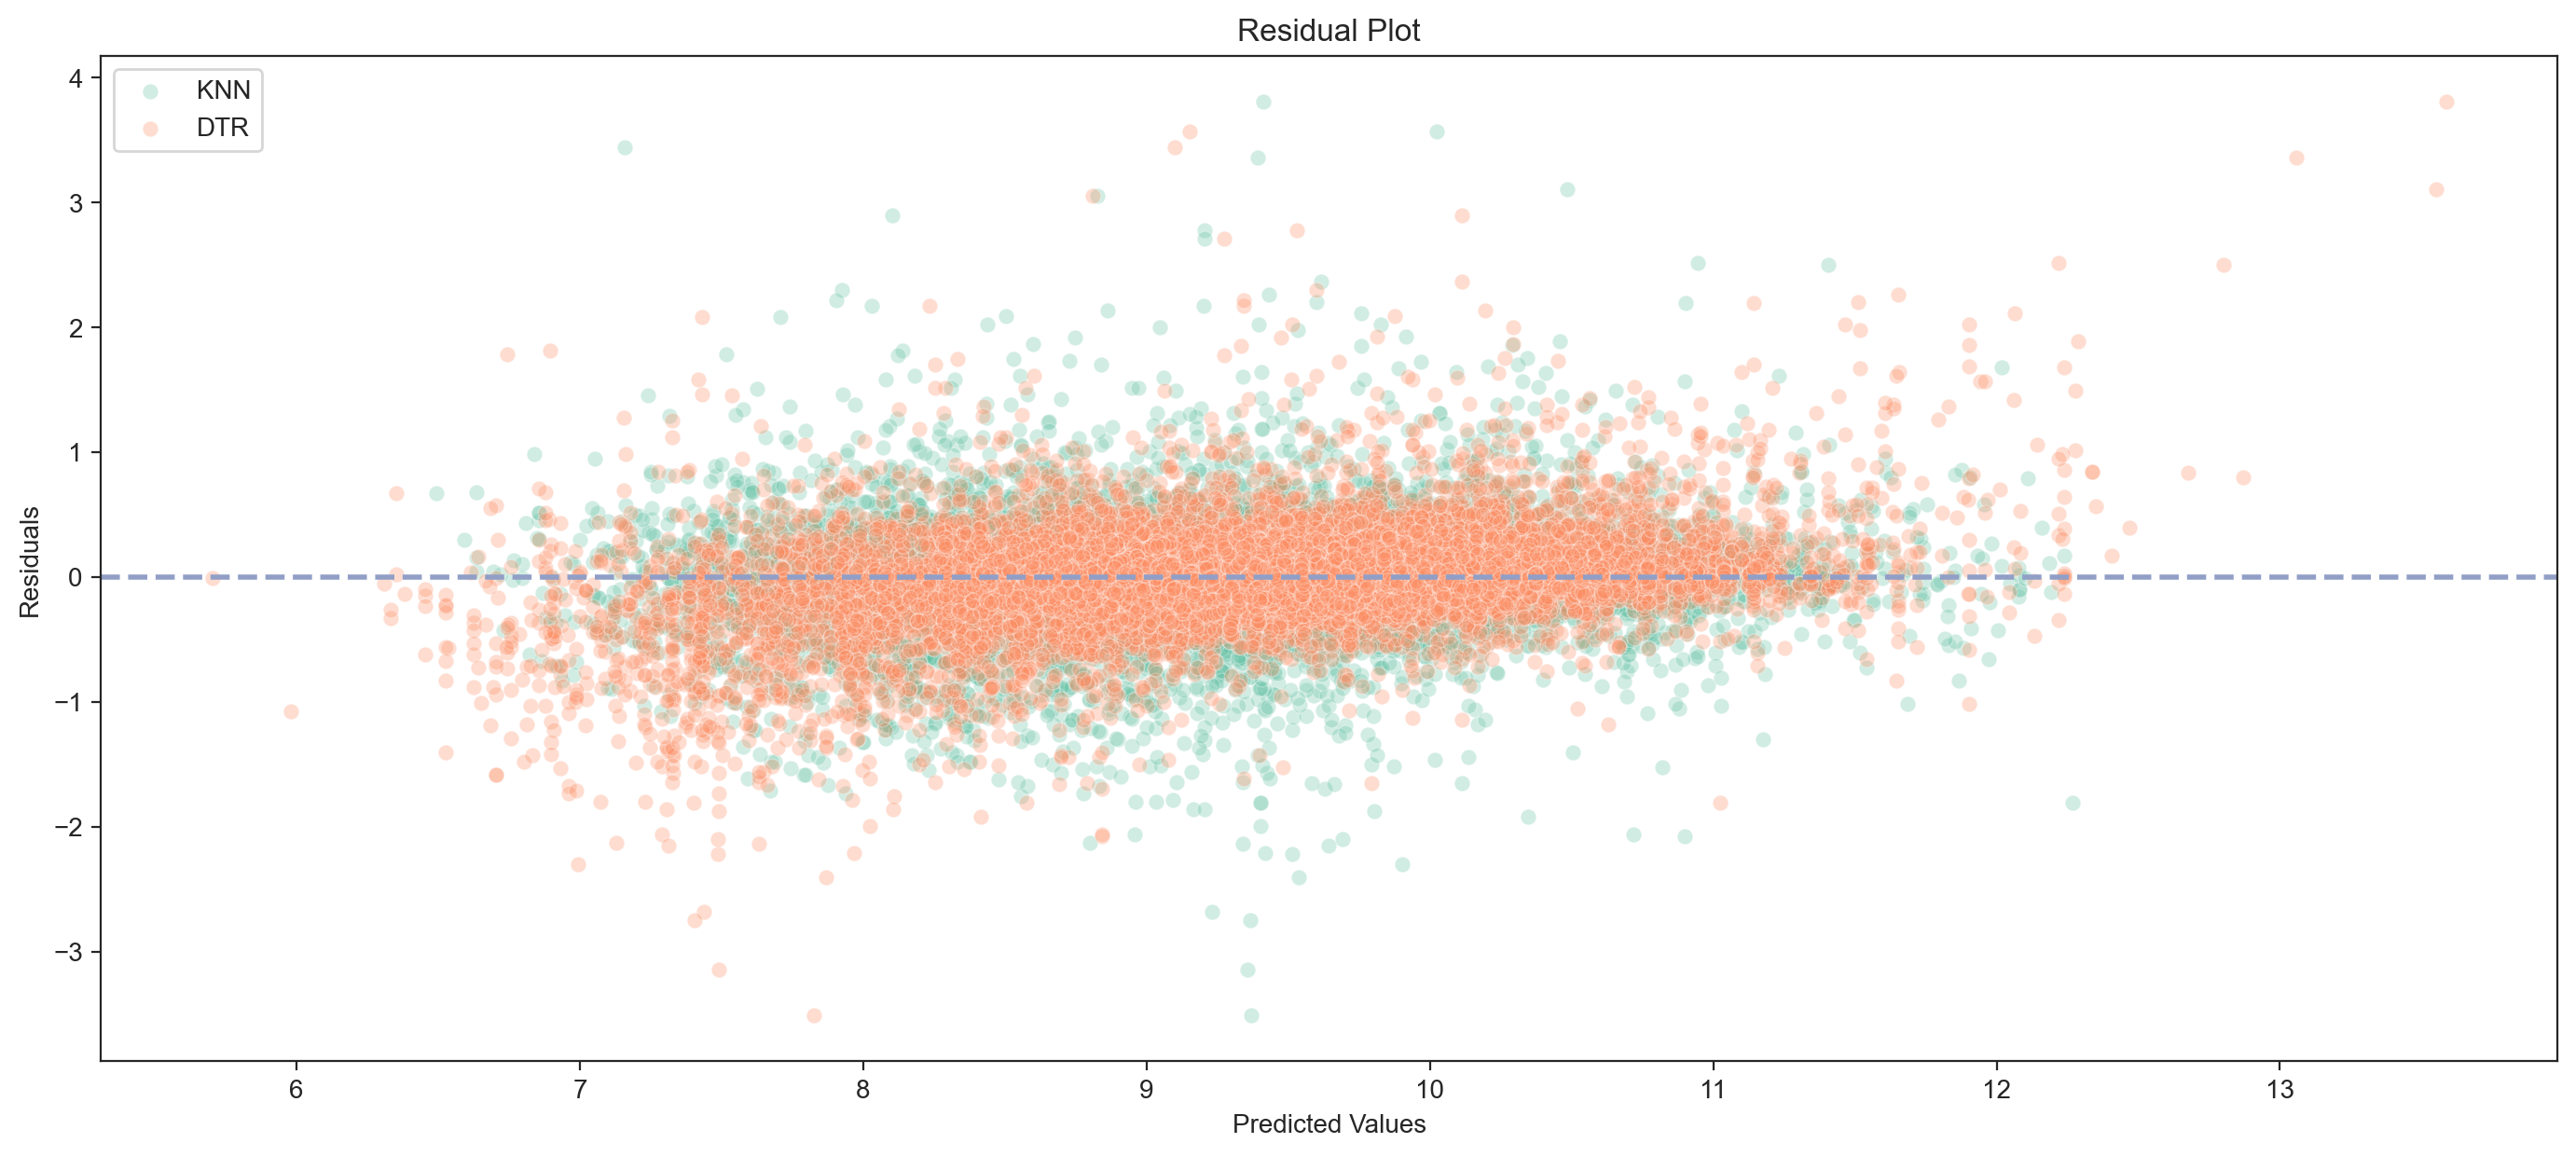

In [ ]:
knn_residuals = prediction_df["Actual"] - prediction_df["KNN_Predicted"]
dtr_residuals = prediction_df["Actual"] - prediction_df["DTR_Predicted"]
lnr_residuals = prediction_df["Actual"] - prediction_df["LNR_Predicted"]

sns.scatterplot(x=prediction_df["KNN_Predicted"], y=knn_residuals, alpha=0.3, label="KNN")
sns.scatterplot(x=prediction_df["DTR_Predicted"], y=knn_residuals, alpha=0.3, label="DTR")
plt.axhline(0, color='#919FC7', linestyle='--', linewidth=2)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot");

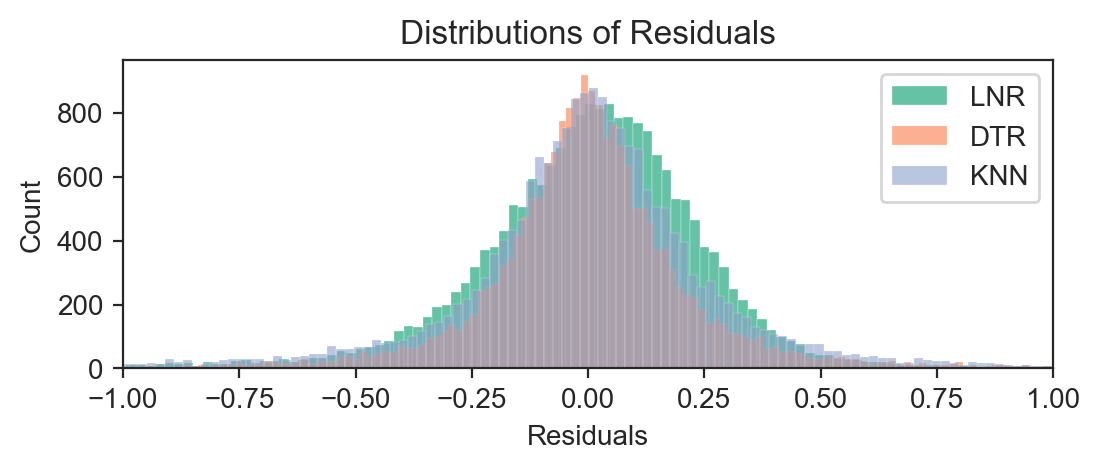

In [ ]:
plt.figure(figsize=(6, 2))
sns.histplot(lnr_residuals, label="LNR", alpha=1)
sns.histplot(dtr_residuals, label="DTR", alpha=0.7)
sns.histplot(knn_residuals, label="KNN", alpha=0.6)
# plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.xlim(-1, 1)
plt.title("Distributions of Residuals")
plt.legend()
plt.xlabel("Residuals")
plt.savefig("/Users/hal/Documents/Essays/AutoML/residuals_dist.png", bbox_inches='tight', dpi=200)

In [ ]:
import plotly.express as px

y_pred = prediction_df["KNN_Predicted"]

fig = px.scatter(x=y_pred, y=knn_residuals, labels={'x': 'Predicted', 'y': 'Residuals'})
fig = px.scatter(x=y_pred, y=dtr_residuals, labels={'x': 'Predicted', 'y': 'Residuals'})
fig.add_shape(type='line', x0=y_pred.min(), y0=0, x1=y_pred.max(), y1=0,
              line=dict(color='Red', dash='dash'))
fig.update_traces(marker=dict(size=8,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

## Tree Vis

In [ ]:
# Load the dataset
auto = pd.read_csv("adverts.csv")
auto = auto.sample(50000, random_state=seed)
X, y = auto.drop(columns="price"), auto[["price"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:
# Load the dataset
auto = pd.read_csv("adverts.csv")
auto = auto.sample(50000, random_state=seed)

X = auto.drop('price', axis=1)
y = auto["price"]
y = np.log(y)

preprocessor.set_params(pre__cat__ohenc__max_categories=5)
X = preprocessor.fit_transform(X)
y = y.loc[X.index]

y = y.reset_index(drop=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:
import dtreeviz
import cairosvg

dtr = DecisionTreeRegressor(max_depth=4)

# Fit the tree
dtr.fit(X_train, y_train)
print(dtr.score(X_test, y_test))

# Create dtreeviz model
vis = dtreeviz.model(
    dtr,
    X_test,
    y_test,
    feature_names=preprocessor.get_feature_names_out(),
    target_name='log_price')

v = vis.view(fontname='sans-serif', scale=2)
v.save("tree.svg") 

cairosvg.svg2png(url="tree.svg", write_to="tree.png") # Adjust scale as needed

0.6414689466453777


## Linear Model

In [ ]:
X = preprocessor.fit_transform(X)
y = auto["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# R2 by default amount of variance of the target explained by the model
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.9065907335014188, 0.8988784716459843)

<Figure size 800x800 with 0 Axes>

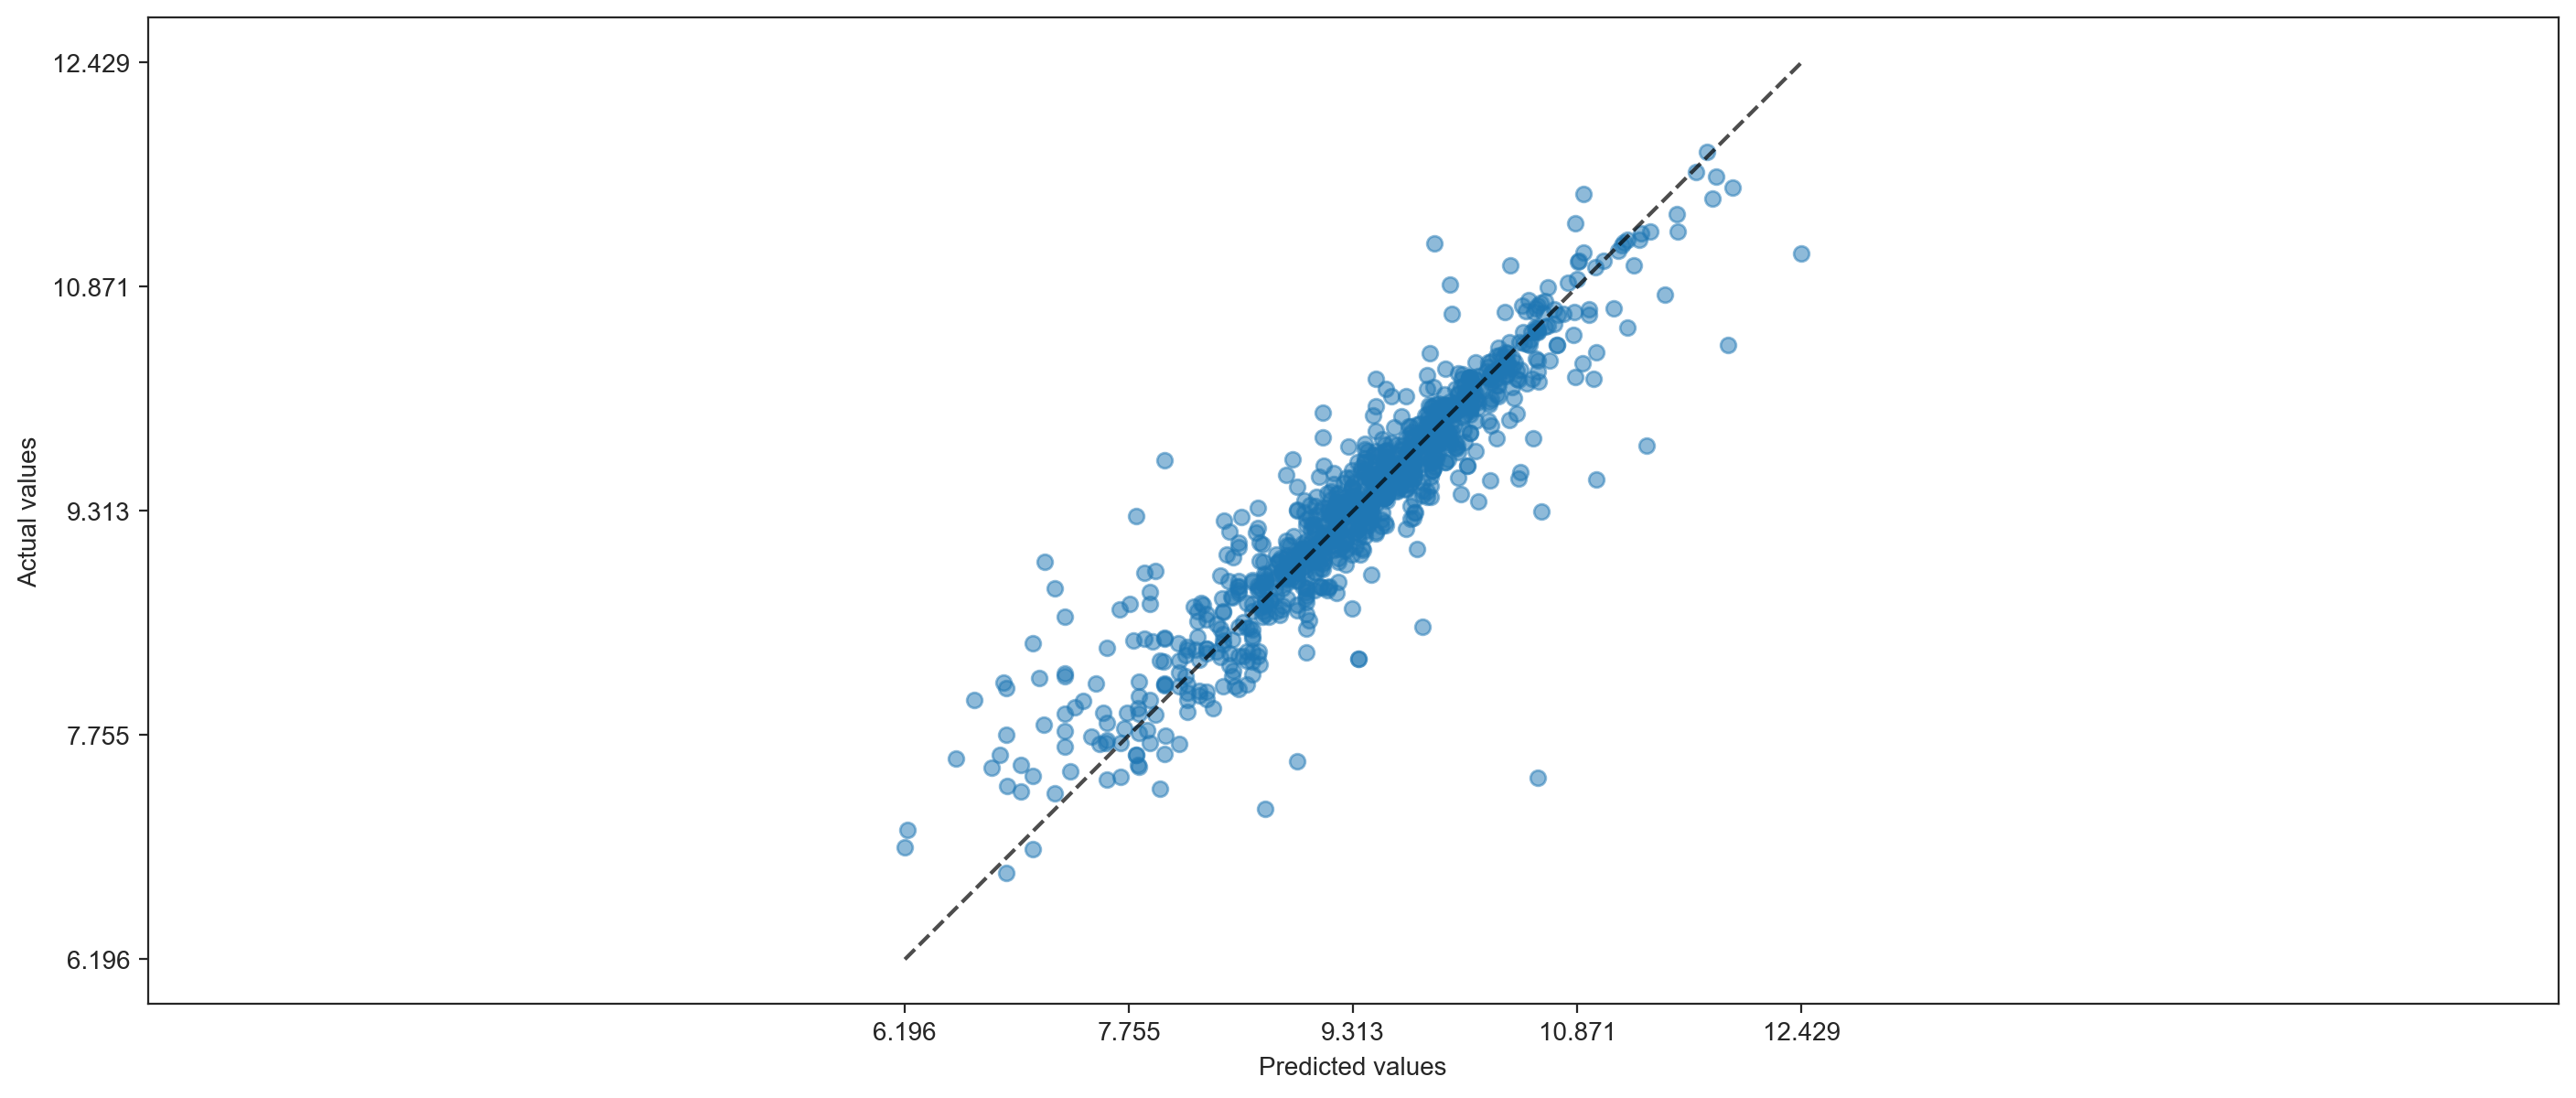

In [ ]:
from sklearn.metrics import PredictionErrorDisplay

plt.figure(figsize=(8, 8))
PredictionErrorDisplay.from_predictions(
    prediction_df["KNN_Predicted"], prediction_df["Actual"],
    kind="actual_vs_predicted",
    scatter_kwargs=dict(alpha=0.5),
)

In [ ]:
# Fits the explainer
explainer = shap.Explainer(lr.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

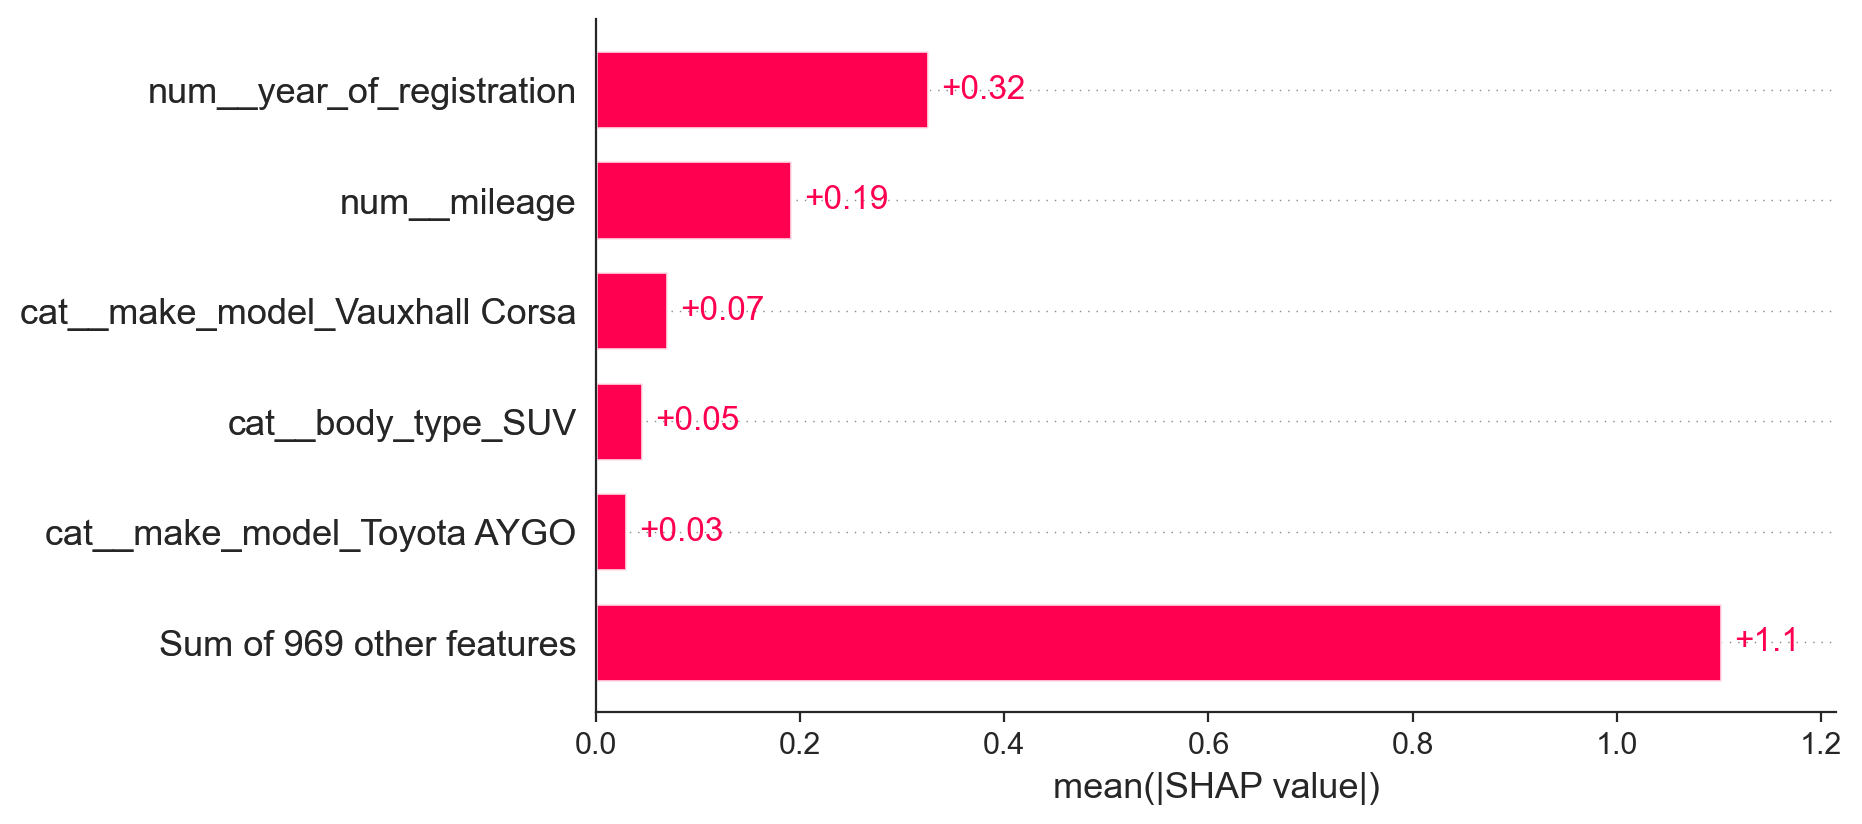

In [ ]:
shap.plots.bar(shap_values, max_display=6)

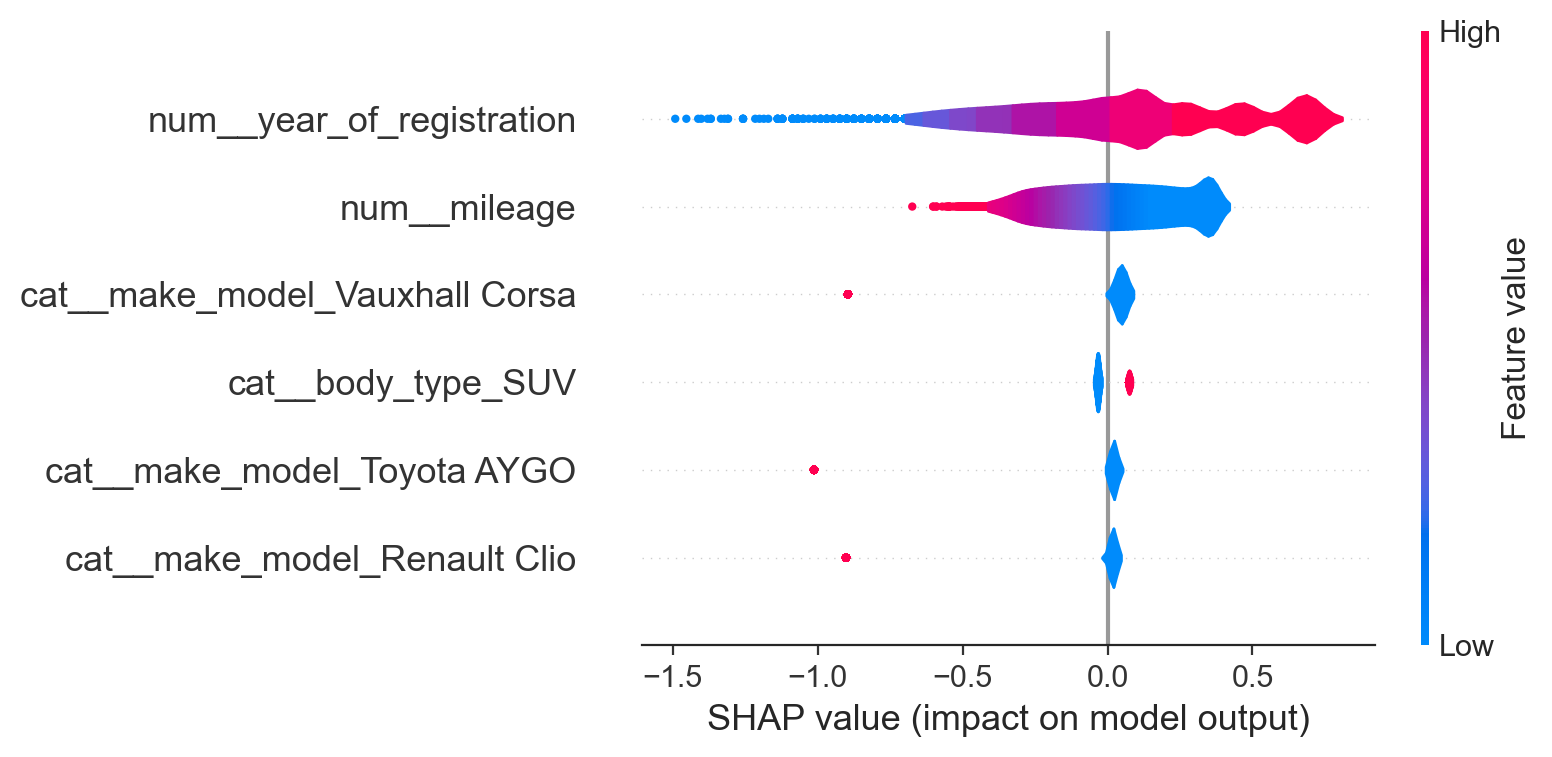

In [ ]:
shap.summary_plot(shap_values, plot_type='violin', max_display=6)

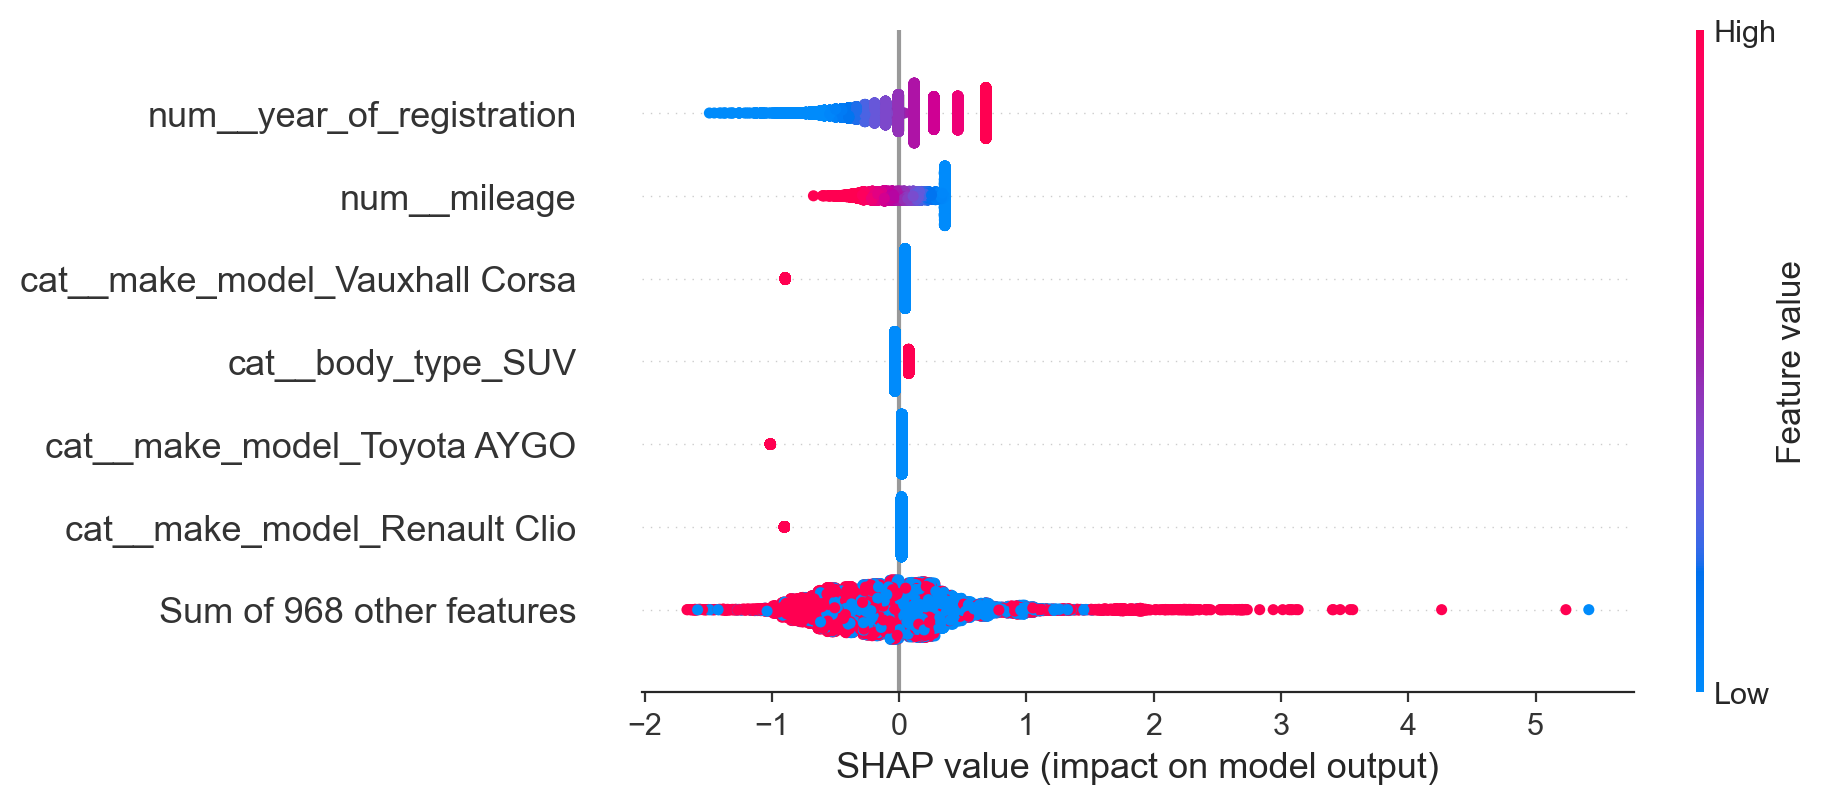

In [ ]:
shap.plots.beeswarm(shap_values, max_display=7)

In [ ]:
auto.loc[(auto["price"]==y_test.iloc[5]) & (auto["standard_model"]=="Yaris")]

public_reference  mileage reg_code standard_colour standard_make  \
301889   202009304408142  16092.0       17            Grey        Toyota   

       standard_model vehicle_condition  year_of_registration    price  \
301889          Yaris              USED                2017.0  9.08137   

        body_type  crossover_car_and_van fuel_type  
301889  Hatchback                  False    Petrol

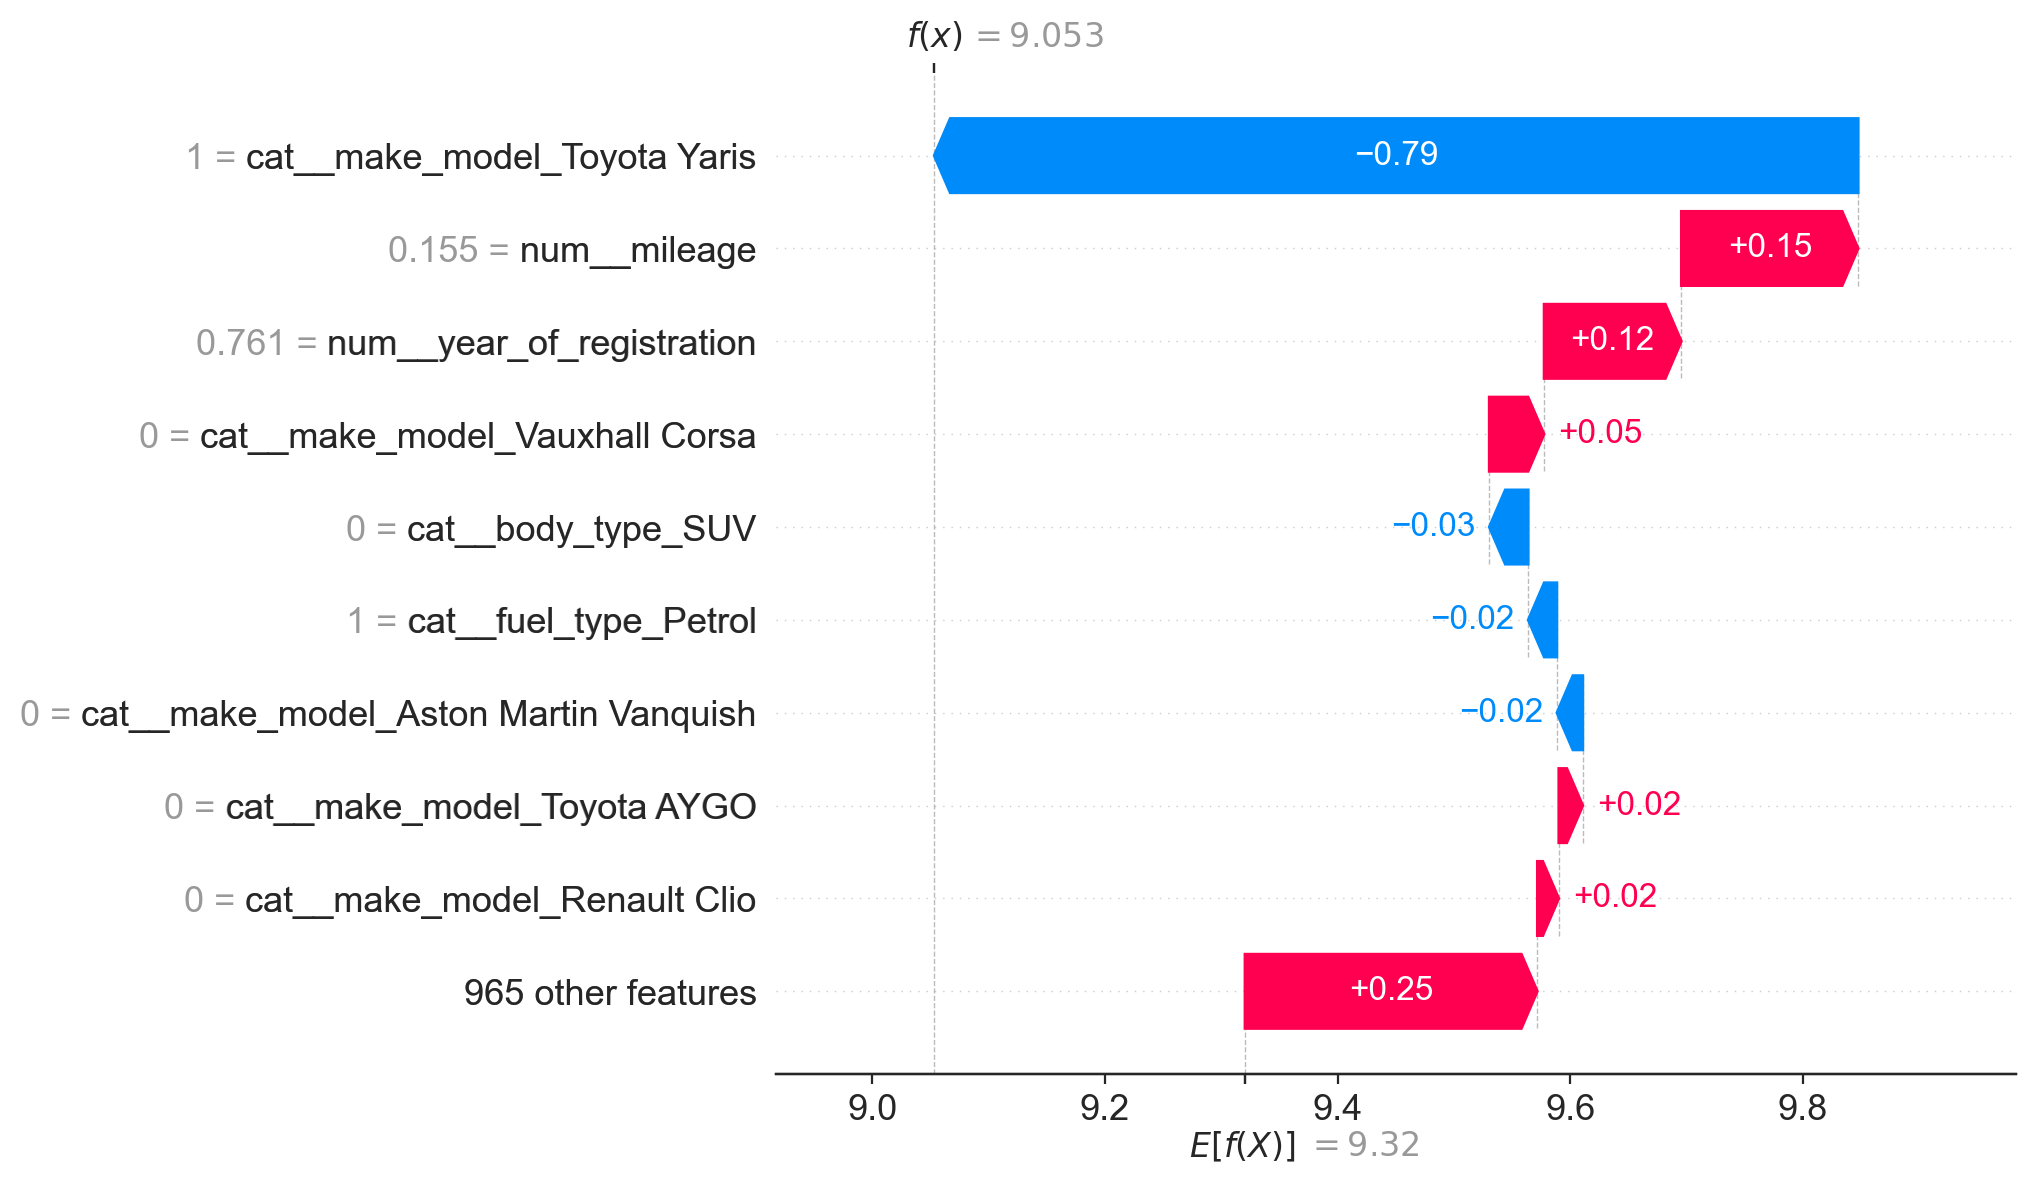

In [ ]:
shap.plots.waterfall(shap_values[5])
# 2017 Used Grey Toyota Yaris, Petrol, 16092.0 miles 

## KNN

In [ ]:
from yellowbrick.regressor import ResidualsPlot

auto_sample = auto.sample(50000, random_state=seed)

X, y = auto_sample.drop(columns=["price"]), auto_sample["price"]

X = preprocessor.fit_transform(X)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1)

0.3216948765661176

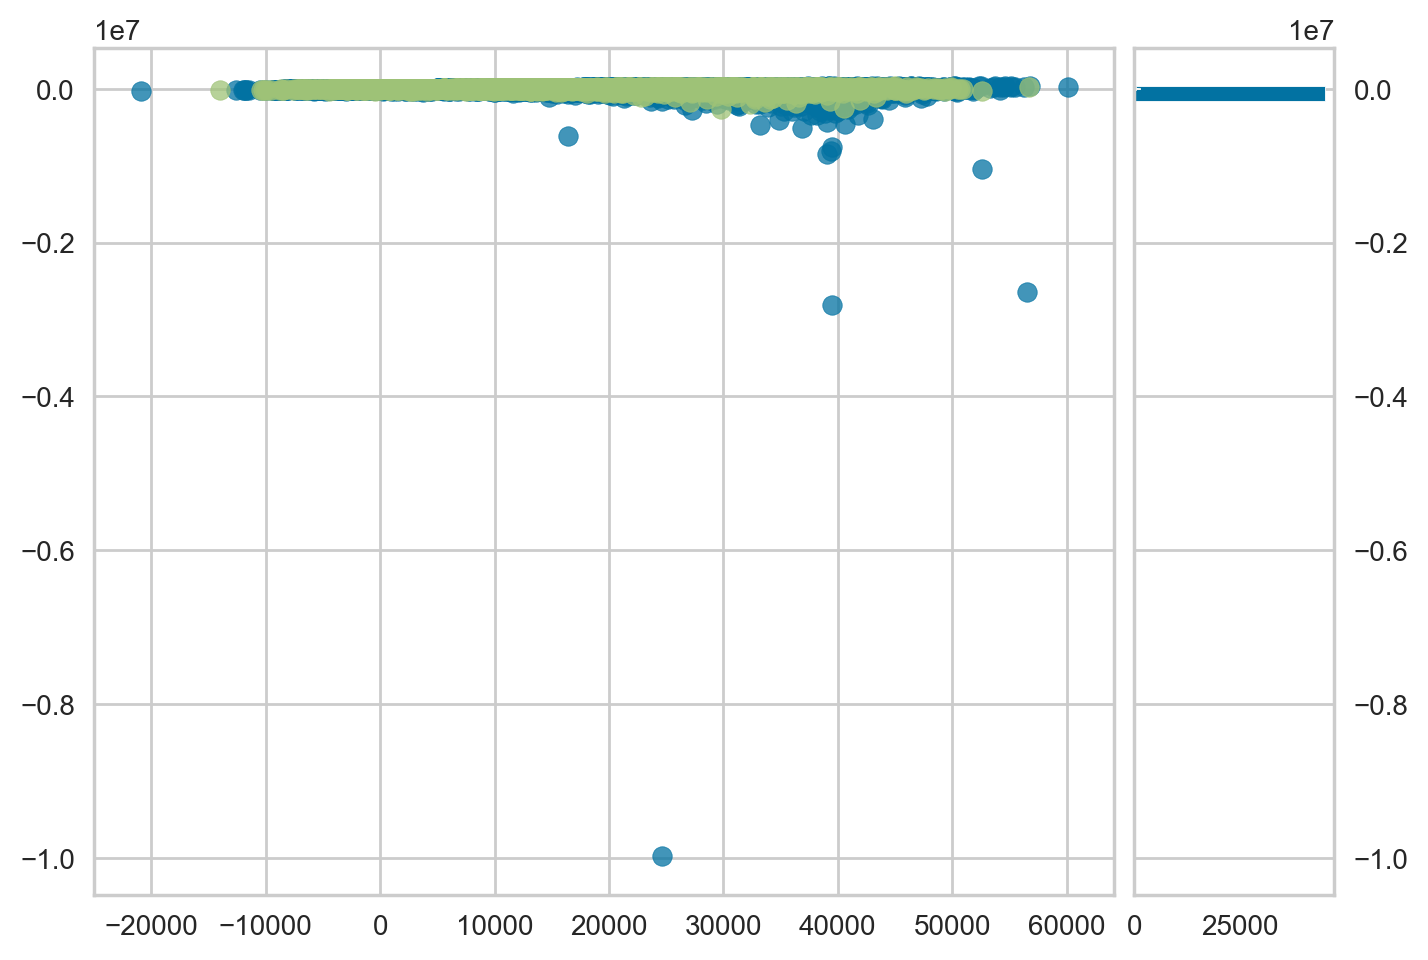

In [ ]:
visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)

0.33213915669959415

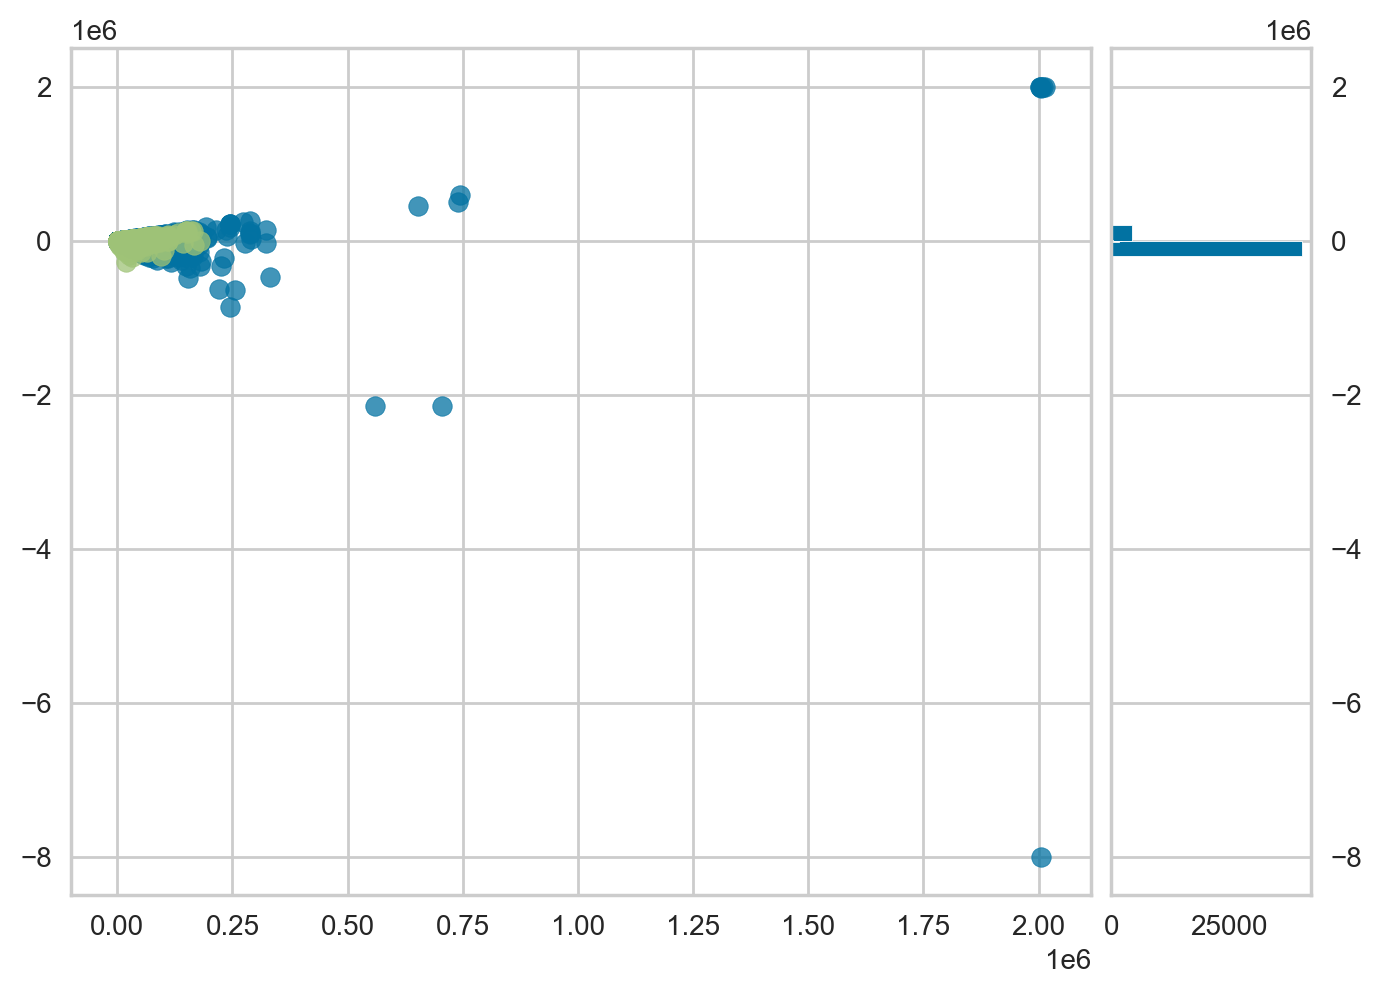

In [ ]:
visualizer = ResidualsPlot(KNeighborsRegressor())
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)

-0.018725072271907228

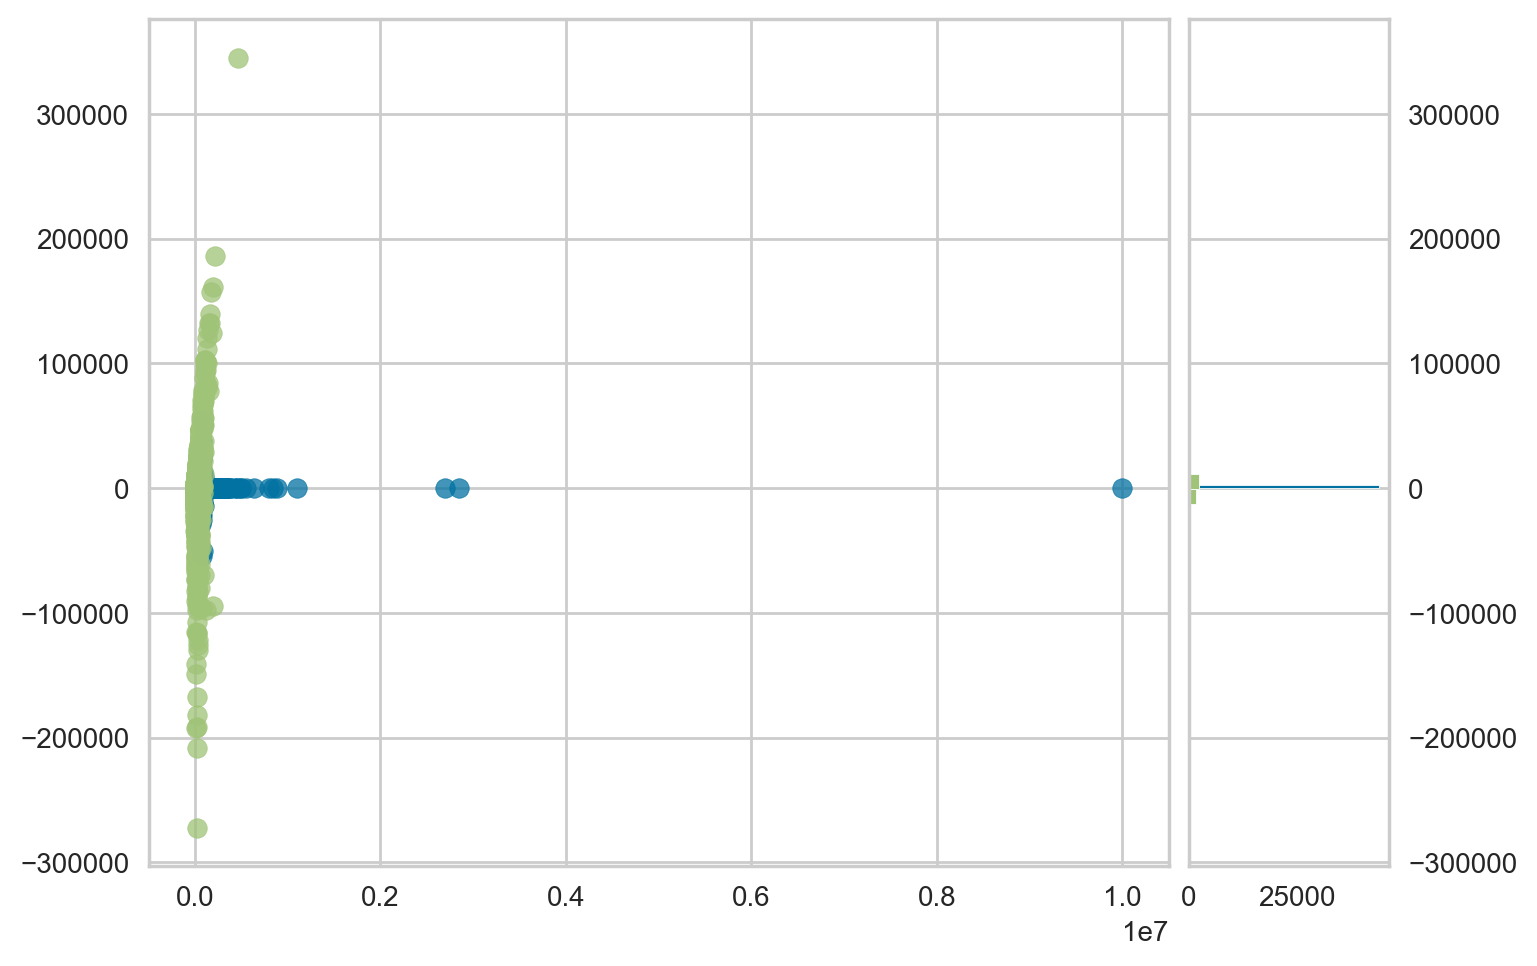

In [ ]:
visualizer = ResidualsPlot(DecisionTreeRegressor(splitter="best", max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2))
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)

In [ ]:
X_train_summary = shap.kmeans(X_train, 10)
ex = shap.KernelExplainer(knn.predict, X_train_summary)
shap_values = ex.shap_values(X_test.iloc[0, :])
shap.force_plot(ex.expected_value, shap_values, X_test.iloc[0, :])

In [ ]:
shap.force_plot(ex.expected_value, shap_values, X_test)